In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from harmony import harmonize
import anndata as ad
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scipy.sparse
import json
import gseapy as gp
import os
from gseapy import barplot
import random
import seaborn as sns

In [2]:
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri
import rpy2.robjects as ro
import logging

In [20]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_2260452/2253401465.py:13: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


# Manual Annotation Hu et al (for reviewer, not used in publication)

In [8]:
adata = sc.read_h5ad("healthy_mapping/Hu/Hu.h5ad") # filtered acc to authors, added sample column

In [3]:
adata.obs["sample"].value_counts()

sample
S1_CA     22659
S2_CA1    15035
S2_CA2    14676
S2_AO     12020
S1_AO     10031
S2_PA      9844
S3_CA1     9821
S3_AO1     8363
S3_AO2     8327
S3_CA2     7783
S3_PA      6697
Name: count, dtype: int64

In [9]:
# Copy the data
adata_pp = adata.copy()

# Normalize data
print("Normalize the data...")
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

# Setup rpy2 and suppress R warnings
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()

# Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

# Define the R script as a string
r_script = """
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)
"""

# Execute the R script
ro.globalenv['data_mat'] = data_mat
ro.globalenv['input_groups'] = input_groups
ro.r(r_script)
size_factors = ro.globalenv['size_factors']

# Remove intermediate adata_pp
del adata_pp

# Normalize adata
adata.obs['size_factors'] = size_factors
adata.X /= adata.obs['size_factors'].values[:, None]
sc.pp.log1p(adata)

# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)

Normalize the data...


/tmp/ipykernel_1118883/3261595106.py:17: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [10]:
adata.write("healthy_mapping/Hu/Hu_normalized.h5ad")

In [12]:
adata

AnnData object with n_obs × n_vars = 125256 × 25335
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'sample', 'size_factors'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'original_gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [14]:
adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="sample")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


In [15]:
adata.write("healthy_mapping/Hu/Hu_normalized_harmony.h5ad")

In [3]:
adata = sc.read_h5ad("healthy_mapping/Hu/Hu_normalized_harmony.h5ad")

In [4]:
adata.var

gene_ids    feature_types     mt  n_cells_by_counts  \
gene_ids                                                                      
ENSG00000238009  ENSG00000238009  Gene Expression  False                 55   
ENSG00000236601  ENSG00000236601  Gene Expression  False                  4   
ENSG00000237491  ENSG00000237491  Gene Expression  False                586   
ENSG00000177757  ENSG00000177757  Gene Expression  False                136   
ENSG00000225880  ENSG00000225880  Gene Expression  False               1974   
...                          ...              ...    ...                ...   
ENSG00000278384  ENSG00000278384  Gene Expression  False                220   
ENSG00000276345  ENSG00000276345  Gene Expression  False               1320   
ENSG00000277856  ENSG00000277856  Gene Expression  False                  7   
ENSG00000275063  ENSG00000275063  Gene Expression  False                  6   
ENSG00000271254  ENSG00000271254  Gene Expression  False               2110   

                 mean_counts  pct_dropout_by_counts  total_counts  n_cells  \
gene_ids                                                                     
ENSG00000238009     0.000425              99.957517          55.0       55   
ENSG00000236601     0.000031              99.996910           4.0        4   
ENSG00000237491     0.004580              99.547368         593.0      586   
ENSG00000177757     0.001050              99.894952         136.0      136   
ENSG00000225880     0.015626              98.475264        2023.0     1974   
...                      ...                    ...           ...      ...   
ENSG00000278384     0.001707              99.830070         221.0      220   
ENSG00000276345     0.010428              98.980419        1350.0     1320   
ENSG00000277856     0.005384              99.994593         697.0        7   
ENSG00000275063     0.003638              99.995366         471.0        6   
ENSG00000271254     0.016730              98.370216        2166.0     2110   

                original_gene_names  highly_variable     means  dispersions  \
gene_ids                                                                      
ENSG00000238009          AL627309.1            False  0.000425     0.563375   
ENSG00000236601          AL732372.1            False  0.000055     0.865939   
ENSG00000237491          AL669831.5            False  0.005941     1.130628   
ENSG00000177757              FAM87B            False  0.001039     1.074426   
ENSG00000225880           LINC00115            False  0.020760     1.006177   
...                             ...              ...       ...          ...   
ENSG00000278384          AL354822.1            False  0.001985     0.775370   
ENSG00000276345          AC004556.1            False  0.009575     0.576349   
ENSG00000277856          AC233755.2             True  0.007901     6.516585   
ENSG00000275063          AC233755.1             True  0.002709     5.277888   
ENSG00000271254          AC240274.1            False  0.018640     1.029151   

                 dispersions_norm  
gene_ids                           
ENSG00000238009         -0.413359  
ENSG00000236601          0.085032  
ENSG00000237491          0.521036  
ENSG00000177757          0.428458  
ENSG00000225880          0.316036  
...                           ...  
ENSG00000278384         -0.064155  
ENSG00000276345         -0.391988  
ENSG00000277856          9.392918  
ENSG00000275063          7.352506  
ENSG00000271254          0.353879  

[25335 rows x 13 columns]

In [5]:
adata.var['ensembl_id'] = adata.var.index.values
adata.var.index = adata.var['original_gene_names']

In [6]:
adata.var

gene_ids    feature_types     mt  \
original_gene_names                                            
AL627309.1           ENSG00000238009  Gene Expression  False   
AL732372.1           ENSG00000236601  Gene Expression  False   
AL669831.5           ENSG00000237491  Gene Expression  False   
FAM87B               ENSG00000177757  Gene Expression  False   
LINC00115            ENSG00000225880  Gene Expression  False   
...                              ...              ...    ...   
AL354822.1           ENSG00000278384  Gene Expression  False   
AC004556.1           ENSG00000276345  Gene Expression  False   
AC233755.2           ENSG00000277856  Gene Expression  False   
AC233755.1           ENSG00000275063  Gene Expression  False   
AC240274.1           ENSG00000271254  Gene Expression  False   

                     n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
original_gene_names                                                          
AL627309.1                          55     0.000425              99.957517   
AL732372.1                           4     0.000031              99.996910   
AL669831.5                         586     0.004580              99.547368   
FAM87B                             136     0.001050              99.894952   
LINC00115                         1974     0.015626              98.475264   
...                                ...          ...                    ...   
AL354822.1                         220     0.001707              99.830070   
AC004556.1                        1320     0.010428              98.980419   
AC233755.2                           7     0.005384              99.994593   
AC233755.1                           6     0.003638              99.995366   
AC240274.1                        2110     0.016730              98.370216   

                     total_counts  n_cells original_gene_names  \
original_gene_names                                              
AL627309.1                   55.0       55          AL627309.1   
AL732372.1                    4.0        4          AL732372.1   
AL669831.5                  593.0      586          AL669831.5   
FAM87B                      136.0      136              FAM87B   
LINC00115                  2023.0     1974           LINC00115   
...                           ...      ...                 ...   
AL354822.1                  221.0      220          AL354822.1   
AC004556.1                 1350.0     1320          AC004556.1   
AC233755.2                  697.0        7          AC233755.2   
AC233755.1                  471.0        6          AC233755.1   
AC240274.1                 2166.0     2110          AC240274.1   

                     highly_variable     means  dispersions  dispersions_norm  \
original_gene_names                                                             
AL627309.1                     False  0.000425     0.563375         -0.413359   
AL732372.1                     False  0.000055     0.865939          0.085032   
AL669831.5                     False  0.005941     1.130628          0.521036   
FAM87B                         False  0.001039     1.074426          0.428458   
LINC00115                      False  0.020760     1.006177          0.316036   
...                              ...       ...          ...               ...   
AL354822.1                     False  0.001985     0.775370         -0.064155   
AC004556.1                     False  0.009575     0.576349         -0.391988   
AC233755.2                      True  0.007901     6.516585          9.392918   
AC233755.1                      True  0.002709     5.277888          7.352506   
AC240274.1                     False  0.018640     1.029151          0.353879   

                          ensembl_id  
original_gene_names                   
AL627309.1           ENSG00000238009  
AL732372.1           ENSG00000236601  
AL669831.5           ENSG00000237491  
FAM87B               ENSG00000177757  
LINC00115            ENSG00000225

In [7]:
level1_marker = {
    'Bcell': ['CD79A', 'CD79B', 'MS4A1', 'IGKC', 'CD22', 'FCER2'],
    'Plasma cell': ['IGKC', 'IGHM', 'IGHA1', 'IGLC2', 'IGLC3', 'JCHAIN'],
    'Tcell': ['CD2', 'TRAC', 'CD69', 'CD3D', 'CD3E', 'CD4', 'CD8A', 'CD8B', 'EOMES', 'LAG3'],
    'NK': ['NKG7', 'XCL1', 'CTSW', 'XCL2', 'CD160', 'FCGR3A', 'PRF1', 'GNLY'],
    'DC': ['CLEC10A', 'FCER1A', 'CD1C', 'HLA-DRA', 'HLA-DRB1'],
    "pDC" : ['CLEC4C', 'LILRA4', 'IL3RA', 'TCF4', 'TCL1A', 'SPIB', 'GZMB', 'NRP1', 'IRF7', 'IRF8', 'SLC15A4'],
    'EC': ['PECAM1', 'VWF', 'FABP4', 'CLDN5', 'IFI27', 'ECSCR', 'DYSF', 'CD34', 'COL4A1', 'COL4A2', 'SPARCL1', 'PLVAP', 'MPZL2', 'SULF1', 'EDN1'],
    'Fibroblast': ['LUM', 'DCN', 'COL1A1', 'COL1A2', 'FBLN1', 'THY1', "C3", "C7"],
    'Fibromyocyte': ['FN1', 'LUM', 'TNFRSF11B', 'ACTA2', 'TCF21'],
    'Fibromyocyte_miller': ["FN1", "VCAN", "LTBP1", "COL4A2", "COL6A2"],
    'SMC': ['ACTA2', 'MYH11', 'MYL9', 'TPM2', 'CALD1', 'TAGLN', 'TNFRSF11B', 'LUM', 'APOE', 'APOC1', 'AGT', 'NOTCH3', 'PDGFRB', 'MFAP4'],
    'Macrophage': ['C1QA', 'C1QB', 'C1QC', 'CD74', 'CXCL8', 'AIF1', 'CD14', 'CD68', 'ITGAM', 'CSF1R', 'HLA-DRA', 'LGALS3'],
    'Monocyte': ['FCN1', 'S100A8', 'S100A9', 'S100A12', 'VCAN', 'CD52', 'LYZ', 'CTSS'],
    'Mast': ['TPSAB1', 'TPSB2', 'KIT', 'HDC', 'CMA1'],
    "Neutrophils_atlas": ['IFITM2','NAMPT','G0S2','CXCL8','SRGN','SOD2','FTH1','NEAT1','FCGR3B','BCL2A1']
}

marker_genes_in_data = {}
for celltype in level1_marker:
    marker_genes_in_data[celltype] = list(set(level1_marker[celltype]).intersection(adata.var_names))
    print(celltype, len(set(level1_marker[celltype]).intersection(adata.var_names))/len(level1_marker[celltype]))
    print("not included: ", set(level1_marker[celltype]).difference(adata.var_names))

Bcell 1.0
not included:  set()
Plasma cell 1.0
not included:  set()
Tcell 1.0
not included:  set()
NK 1.0
not included:  set()
DC 1.0
not included:  set()
pDC 1.0
not included:  set()
EC 1.0
not included:  set()
Fibroblast 1.0
not included:  set()
Fibromyocyte 1.0
not included:  set()
Fibromyocyte_miller 1.0
not included:  set()
SMC 1.0
not included:  set()
Macrophage 1.0
not included:  set()
Monocyte 1.0
not included:  set()
Mast 1.0
not included:  set()
Neutrophils_atlas 1.0
not included:  set()


In [15]:
adata

AnnData object with n_obs × n_vars = 125256 × 25335
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'sample', 'size_factors', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'original_gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
sc.pp.neighbors(adata, use_rep="Harmony")
sc.tl.umap(adata)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
sc.tl.leiden(adata, resolution = 0.8)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


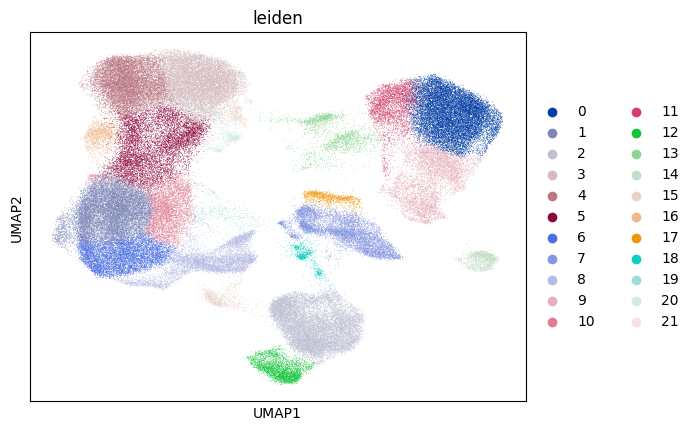

In [13]:
sc.pl.umap(adata, color= ['leiden'])

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

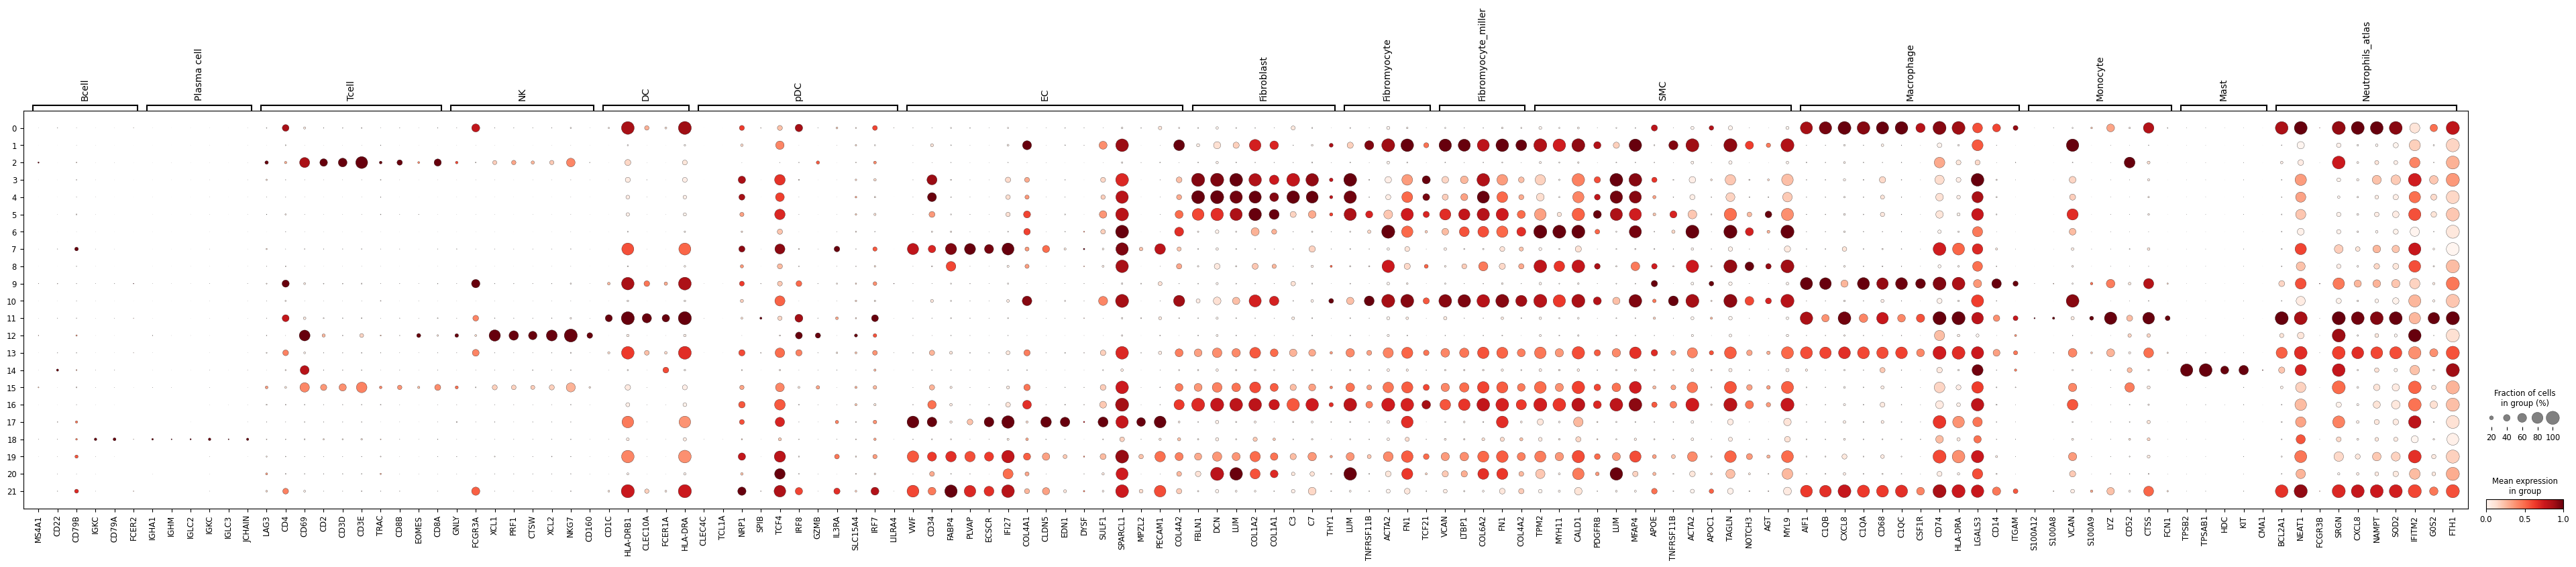

In [17]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="dotplot_hu.png"
)

In [18]:
annotation = {
    "0": "Macrophage/neutro",
    "1": "Fibromyo/SMC",
    "2": "T cell",
    "3": "Fibroblast",
    "4": "Fibroblast",
    "5": "Fibroblast",
    "6": "SMC",
    "7": "EC",
    "8": "SMC",
    "9": "Macrophage",
    "10": "Fibromyo",
    "11": "DC/neutro",
    "12": "NK",
    "13": "unknown",
    "14": "Mast",
    "15": "unknown",
    "16": "unknown",
    "17": "EC",
    "18": "Plasma",
    "19": "unknown",
    "20": "unknown",
    "21": "unknown"
}
adata.obs["cell_type_level1"] = adata.obs.leiden.map(annotation)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


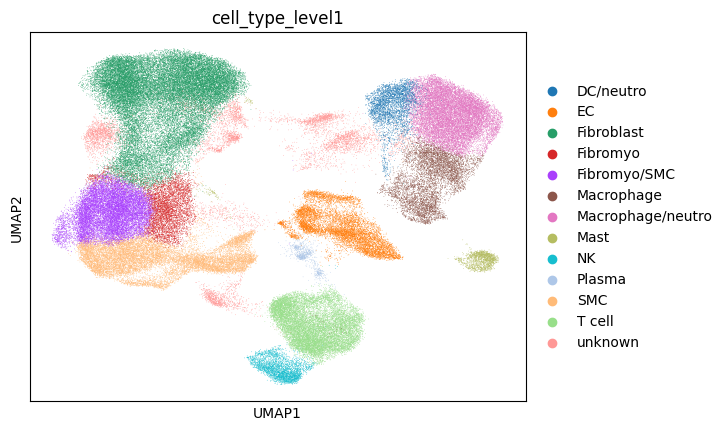

In [19]:
sc.pl.umap(adata, color= ['cell_type_level1'])

In [20]:
adata.obs["cell_type_level1"].value_counts()

cell_type_level1
Fibroblast           32449
Macrophage/neutro    14785
SMC                  14061
Fibromyo/SMC         13807
T cell               13705
EC                    8465
unknown               7518
Macrophage            6359
Fibromyo              4976
DC/neutro             3569
NK                    3044
Mast                  1660
Plasma                 858
Name: count, dtype: int64

In [21]:
adata_unknown = adata[adata.obs["cell_type_level1"]=="unknown"]

In [22]:
adata_unknown

View of AnnData object with n_obs × n_vars = 7518 × 25335
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'sample', 'size_factors', 'leiden', 'cell_type_level1'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'original_gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors', 'cell_type_level1_colors'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
sc.pp.highly_variable_genes(adata_unknown, n_top_genes=2000, subset=False)
sc.pp.pca(adata_unknown, svd_solver="arpack", use_highly_variable=True)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:544: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


In [24]:
adata_unknown.obsm["Harmony"] = harmonize(adata_unknown.obsm["X_pca"], adata_unknown.obs, batch_key="sample")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


In [25]:
sc.pp.neighbors(adata_unknown, use_rep="Harmony")
sc.tl.umap(adata_unknown)

In [27]:
sc.tl.leiden(adata_unknown, resolution = 0.5)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


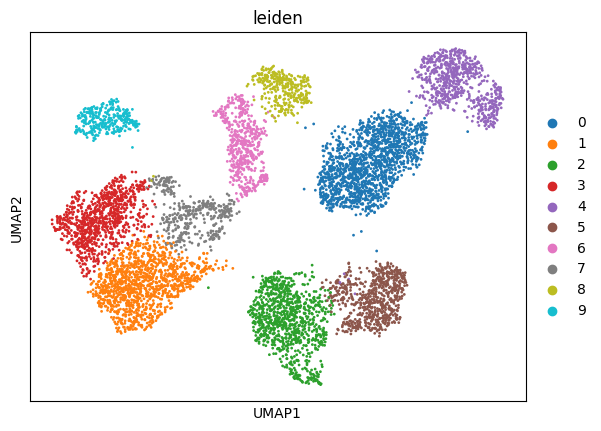

In [28]:
sc.pl.umap(adata_unknown, color= ['leiden'])

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

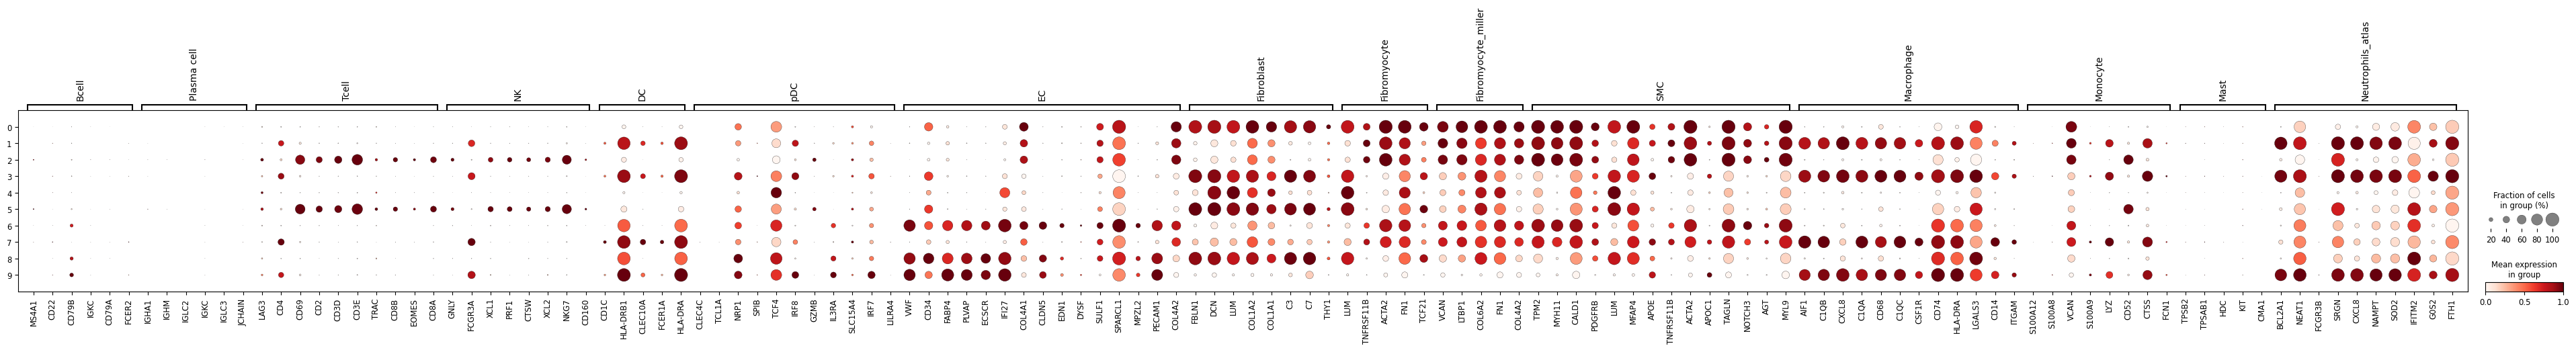

In [30]:
sc.pl.dotplot(
    adata_unknown,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="dotplot_hu_unknown.png"
)

In [31]:
annotation = {
    "0": "Fibromyocyte",
    "1": "Fibromyo/SMC/Macro/Neutro",
    "2": "T cell/SMC/Fibromyo",
    "3": "Fibro/Macro/neutro",
    "4": "Fibroblast",
    "5": "T cell/Fibro",
    "6": "EC",
    "7": "Macro/DC",
    "8": "EC/Fibro",
    "9": "EC/Macro/Neutro"
}
adata_unknown.obs["cell_type_level1"] = adata_unknown.obs.leiden.map(annotation)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


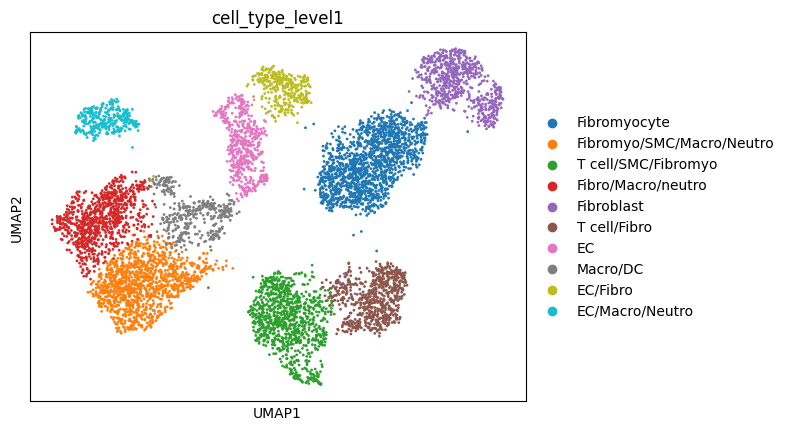

In [32]:
sc.pl.umap(adata_unknown, color= ['cell_type_level1'])

In [37]:
# Convert 'cell_type_level1' to string type in both adata objects
adata.obs['cell_type_level1'] = adata.obs['cell_type_level1'].astype(str)
adata_unknown.obs['cell_type_level1'] = adata_unknown.obs['cell_type_level1'].astype(str)

# Now, assign the updated annotations from adata_unknowns to adata
adata.obs.loc[adata_unknown.obs.index, 'cell_type_level1'] = adata_unknown.obs['cell_type_level1']

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


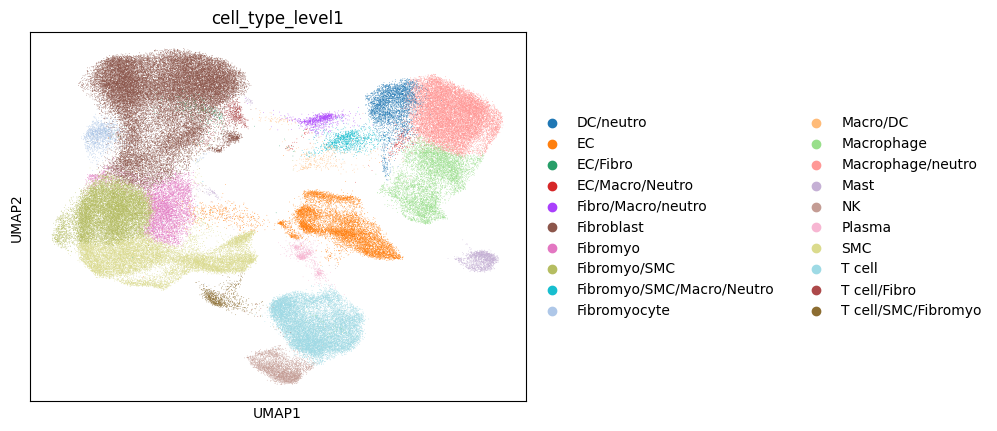

In [38]:
sc.pl.umap(adata, color= ['cell_type_level1'])

In [39]:
adata.write("Huetall_manual_annot_1.h5ad")

## compare with atlas predictions

In [52]:
adata = sc.read_h5ad("Huetall_manual_annot_1.h5ad")

In [53]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGAAACCAT-S1_AO               2302        5174.0            103.0   
AAACCTGAGATATGCA-S1_AO               1810        8041.0            222.0   
AAACCTGAGATCTGCT-S1_AO               1199        5238.0            207.0   
AAACCTGAGCTCAACT-S1_AO               3609       19471.0            846.0   
AAACCTGAGGGCTTCC-S1_AO               1273        3491.0            212.0   
...                                   ...           ...              ...   
TTTGTCAGTGTGTGCC-S3_PA               1453        4622.0            103.0   
TTTGTCATCACTTCAT-S3_PA               1048        2507.0            157.0   
TTTGTCATCCATGAGT-S3_PA               1083        2118.0             70.0   
TTTGTCATCTATCCCG-S3_PA               3391       12106.0             89.0   
TTTGTCATCTCGCTTG-S3_PA               1098        3018.0             22.0   

                        pct_counts_mt  n_genes sample  size_factors leiden  \
AAACCTGAGAAACCAT-S1_AO       1.990723     2301  S1_AO      1.391025     18   
AAACCTGAGATATGCA-S1_AO       2.760851     1810  S1_AO      0.990352      0   
AAACCTGAGATCTGCT-S1_AO       3.951890     1199  S1_AO      0.642155     11   
AAACCTGAGCTCAACT-S1_AO       4.344923     3609  S1_AO      2.914036      7   
AAACCTGAGGGCTTCC-S1_AO       6.072759     1273  S1_AO      0.617221      8   
...                               ...      ...    ...           ...    ...   
TTTGTCAGTGTGTGCC-S3_PA       2.228472     1453  S3_PA      0.649005      7   
TTTGTCATCACTTCAT-S3_PA       6.262465     1048  S3_PA      0.446661      2   
TTTGTCATCCATGAGT-S3_PA       3.305005     1083  S3_PA      0.474466      4   
TTTGTCATCTATCCCG-S3_PA       0.735173     3390  S3_PA      2.529079      5   
TTTGTCATCTCGCTTG-S3_PA       0.728960     1098  S3_PA      0.467032      0   

                         cell_type_level1  
AAACCTGAGAAACCAT-S1_AO             Plasma  
AAACCTGAGATATGCA-S1_AO  Macrophage/neutro  
AAACCTGAGATCTGCT-S1_AO          DC/neutro  
AAACCTGAGCTCAACT-S1_AO                 EC  
AAACCTGAGGGCTTCC-S1_AO                SMC  
...                                   ...  
TTTGTCAGTGTGTGCC-S3_PA                 EC  
TTTGTCATCACTTCAT-S3_PA             T cell  
TTTGTCATCCATGAGT-S3_PA         Fibroblast  
TTTGTCATCTATCCCG-S3_PA         Fibroblast  
TTTGTCATCTCGCTTG-S3_PA  Macrophage/neutro  

[125256 rows x 9 columns]

In [54]:
adata_atlas = sc.read_h5ad("/home/icb/korbinian.traeuble/projects/Roche/hpc-data-transfer/Roche_main/data/Plaque-atlas/healthy_mapping/Hu/Hu_embedding_level1.h5ad")

In [55]:
adata_atlas.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGAAACCAT-S1_AO             2302.0        5174.0            103.0   
AAACCTGAGATATGCA-S1_AO             1810.0        8041.0            222.0   
AAACCTGAGATCTGCT-S1_AO             1199.0        5238.0            207.0   
AAACCTGAGCTCAACT-S1_AO             3609.0       19471.0            846.0   
AAACCTGAGGGCTTCC-S1_AO             1273.0        3491.0            212.0   
...                                   ...           ...              ...   
TTTGTCAGTGTGTGCC-S3_PA             1453.0        4622.0            103.0   
TTTGTCATCACTTCAT-S3_PA             1048.0        2507.0            157.0   
TTTGTCATCCATGAGT-S3_PA             1083.0        2118.0             70.0   
TTTGTCATCTATCCCG-S3_PA             3391.0       12106.0             89.0   
TTTGTCATCTCGCTTG-S3_PA             1098.0        3018.0             22.0   

                        pct_counts_mt       sample  n_genes  size_factors  \
AAACCTGAGAAACCAT-S1_AO       1.990723  S1_AO_query   2301.0      1.404402   
AAACCTGAGATATGCA-S1_AO       2.760851  S1_AO_query   1810.0      0.995169   
AAACCTGAGATCTGCT-S1_AO       3.951890  S1_AO_query   1199.0      0.590125   
AAACCTGAGCTCAACT-S1_AO       4.344923  S1_AO_query   3609.0      2.896410   
AAACCTGAGGGCTTCC-S1_AO       6.072759  S1_AO_query   1273.0      0.611794   
...                               ...          ...      ...           ...   
TTTGTCAGTGTGTGCC-S3_PA       2.228472  S3_PA_query   1453.0      0.737632   
TTTGTCATCACTTCAT-S3_PA       6.262465  S3_PA_query   1048.0      0.446538   
TTTGTCATCCATGAGT-S3_PA       3.305005  S3_PA_query   1083.0      0.443565   
TTTGTCATCTATCCCG-S3_PA       0.735173  S3_PA_query   3390.0      2.564962   
TTTGTCATCTCGCTTG-S3_PA       0.728960  S3_PA_query   1098.0      0.486901   

                        cell_type_uncert    cell_type_level1  
AAACCTGAGAAACCAT-S1_AO          0.284557          Fibroblast  
AAACCTGAGATATGCA-S1_AO          0.156829            Monocyte  
AAACCTGAGATCTGCT-S1_AO          0.100376            Monocyte  
AAACCTGAGCTCAACT-S1_AO          0.152225                  EC  
AAACCTGAGGGCTTCC-S1_AO          0.140411  Smooth Muscle Cell  
...                                  ...                 ...  
TTTGTCAGTGTGTGCC-S3_PA          0.159592                  EC  
TTTGTCATCACTTCAT-S3_PA          0.097197             NK cell  
TTTGTCATCCATGAGT-S3_PA          0.031930          Fibroblast  
TTTGTCATCTATCCCG-S3_PA          0.052999          Fibroblast  
TTTGTCATCTCGCTTG-S3_PA          0.166901          Macrophage  

[125256 rows x 9 columns]

In [56]:
atlas_annot = adata_atlas.obs["cell_type_level1"]

In [57]:
adata_atlas.obs['cell_type_level1'] = adata_atlas.obs['cell_type_level1'].astype(str)

In [58]:
# Modify cell_type_level1 based on cell_type_uncert
adata_atlas.obs.loc[adata_atlas.obs['cell_type_uncert'] > 0.5, 'cell_type_level1'] = 'uncertrain'

In [59]:
# Get the barcodes (cell IDs) from both datasets
barcodes_atlas = adata_atlas.obs_names
barcodes_adata = adata.obs_names

# Find common barcodes
common_barcodes = barcodes_atlas.intersection(barcodes_adata)

# Subset the annotations to the common barcodes
atlas_annot = adata_atlas[common_barcodes].obs['cell_type_level1'].tolist()
adata_annot = adata[common_barcodes].obs['cell_type_level1'].tolist()

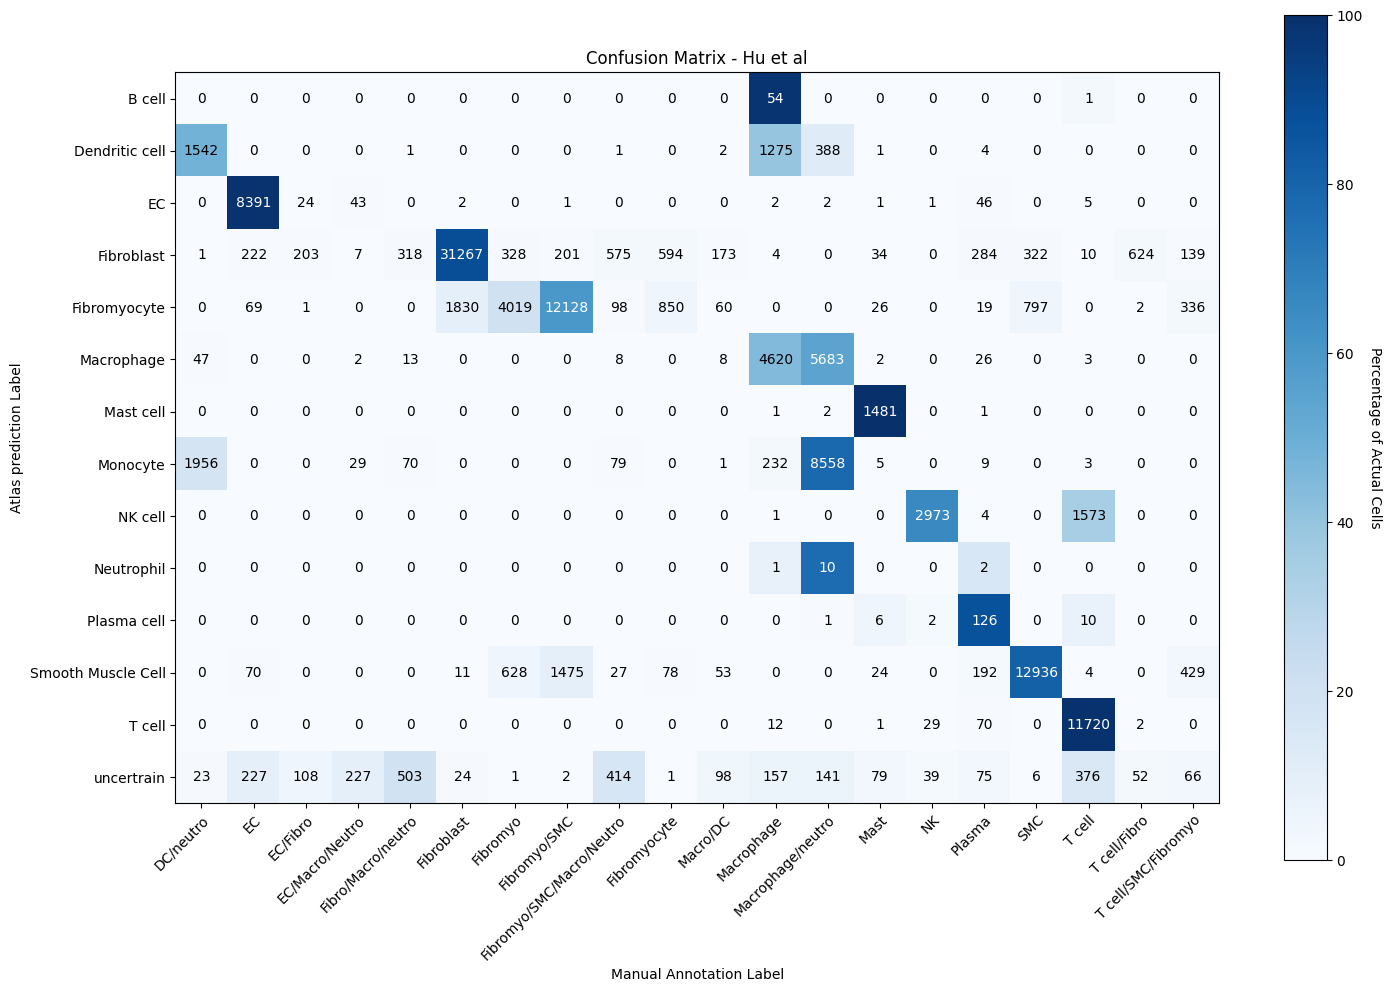

In [60]:
# Unique labels from the true annotations (y-axis)
unique_true_labels = sorted(set(atlas_annot))

# Unique labels from the predicted annotations (x-axis)
unique_pred_labels = sorted(set(adata_annot))

# Create a DataFrame from the annotations
df = pd.DataFrame({'Actual': atlas_annot, 'Predicted': adata_annot})

# Create the confusion matrix with crosstab
conf_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'], dropna=False)

# Reindex the confusion matrix to ensure all labels are included
conf_matrix = conf_matrix.reindex(index=unique_true_labels, columns=unique_pred_labels, fill_value=0)

# Flatten the actual and predicted annotations for metric calculations
actual_flat = df['Actual']
predicted_flat = df['Predicted']

# Calculate overall accuracy
accuracy = accuracy_score(actual_flat, predicted_flat)

# Calculate precision and recall
precision = precision_score(actual_flat, predicted_flat, labels=unique_pred_labels, average=None, zero_division=0)
recall = recall_score(actual_flat, predicted_flat, labels=unique_true_labels, average=None, zero_division=0)
overall_precision = precision_score(actual_flat, predicted_flat, average='weighted', zero_division=0)
overall_recall = recall_score(actual_flat, predicted_flat, average='weighted', zero_division=0)

# Convert the confusion matrix to a numpy array
conf_matrix_array = conf_matrix.values

# Calculate percentages per row (actual class)
row_sums = conf_matrix_array.sum(axis=1, keepdims=True)
conf_matrix_percentages = np.divide(conf_matrix_array, row_sums, out=np.zeros_like(conf_matrix_array, dtype=float), where=row_sums!=0) * 100

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))
norm = colors.Normalize(vmin=0, vmax=100)  # Set vmax to 100 for percentage

im = ax.imshow(conf_matrix_percentages, interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Percentage of Actual Cells', rotation=-90, va="bottom")

# Set tick labels based on unique labels from actual and predicted annotations
ax.set_xticks(np.arange(len(unique_pred_labels)))
ax.set_yticks(np.arange(len(unique_true_labels)))

ax.set_xticklabels(unique_pred_labels)
ax.set_yticklabels(unique_true_labels)

ax.set_xlabel('Manual Annotation Label')
ax.set_ylabel('Atlas prediction Label')
ax.set_title(f'Confusion Matrix - Hu et al')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations (showing the original count)
for i in range(conf_matrix_array.shape[0]):
    for j in range(conf_matrix_array.shape[1]):
        count = conf_matrix_array[i, j]
        percentage = conf_matrix_percentages[i, j]
        ax.text(j, i, f'{int(count)}',
                ha="center", va="center",
                color="white" if percentage > 50 else "black")

fig.tight_layout()
plt.savefig("figures/conf_matrix_Hu.pdf")
#plt.show()

# Tabula Sapiens

In [3]:
tissue = "Bladder"

In [4]:
adata = sc.read_h5ad(f"healthy_mapping/TS/{tissue}2/{tissue}_embedding.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 24583 × 10
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'n_genes', 'size_factors', 'organ_tissue', 'method', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'cell_type_uncert', 'cell_type_level2'

In [3]:
color_palette_level1 = {
    'T cell': '#3182bd',                       # blue for all T cell types
    'Macrophage': '#8c564b',                   # brown for all macrophages
    'Plasma cell': '#ff7f0e',                  # vibrant orange
    'Mast cell': '#d62728',                    # red
    'NK cell': '#98df8a',                      # light green
    'Fibromyocyte': '#f7b6d2',                 # pastel pink
    'Smooth Muscle Cell': '#7b4173',           # deeper purple
    'Fibroblast': '#e377c2',                   # bright pink
    'B cell': '#2ca02c',                       # green
    'Dendritic cell': '#807dba',               # violet for dendritic cells
    'EC': '#fdae6b',                           # orange for all endothelial cells  
    'Monocyte': '#c7c7c7',                     # lighter gray
    'Neutrophil': '#17becf'                    # teal
}

color_palette_level2 = {
    'B cell': '#2ca02c',                       # green

    'CD4 T cell': '#6495ED',                   # Cornflower Blue
    'CD8 T cell': '#0047AB',                   # Cobalt Blue

    'EndoMT EC': '#FFD700',                    # Gold
    'Pro-Angiogenic EC': '#ED9121',            # Carrot Orange
    'EC': 'yellow',                            # Yellow

    'Fibroblast': '#e377c2',                   # bright pink
    'Fibromyocyte': '#f7b6d2',                 # pastel pink
    'Smooth Muscle Cell': '#7b4173',           # deeper purple

    'Other Macrophage': '#ece2d0',              # very light brown
    'TREM2+/Foamy Macrophage': '#c4a484',       # light tan-brown
    'HMOX1+ Macrophage': '#bf9b7a',             # medium brown
    'Inflammatory Macrophage': '#8b4513',       # saddle brown
    'PLIN2+/TREM1+ Macrophage': '#5b3a29',      # dark brown

    'Mast cell': '#d62728',                    # red

    'Monocyte': '#c7c7c7',                     # lighter gray
    'Neutrophil': '#17becf',                   # teal

    'NK cell': '#98df8a',                      # light green

    'Plasma cell': '#9467bd',                  # muted purple

    'Conventional dendritic cell 1': '#d4b9da',  # light violet
    'Conventional dendritic cell 2': '#807dba',  # medium violet
    'Plasmacytoid dendritic cell': '#4a1486'     # deep violet
}

In [8]:
def plot_umap_with_dynamic_colors(adata, color_column, color_palette, title, save_path, tissue):
    # Get unique cell types
    cell_types = adata.obs[color_column].unique()
    
    # Create a color map
    color_map = {}
    for cell_type in cell_types:
        if cell_type in color_palette:
            color_map[cell_type] = color_palette[cell_type]
        else:
            # Generate a random color if not in palette
            random_color = "#"+''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
            color_map[cell_type] = random_color

    sc.settings.figdir = f"healthy_mapping/TS/{tissue}1/"
    
    # Plot
    sc.pl.umap(
        adata,
        color=color_column,
        palette=color_map,
        title=title,
        frameon=False,
        save= save_path #f"{title.replace(' ', '_')}.png"  # Save with a filename based on the title
    )

Starting with Bladder...


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


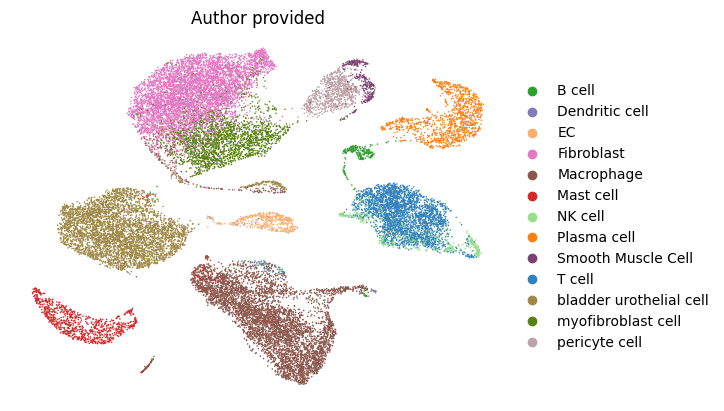

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


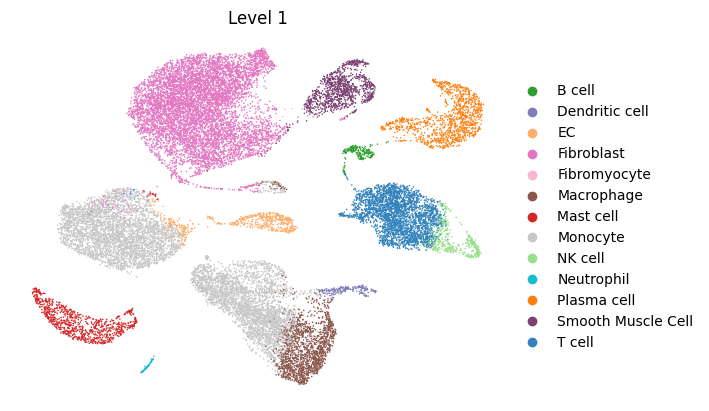

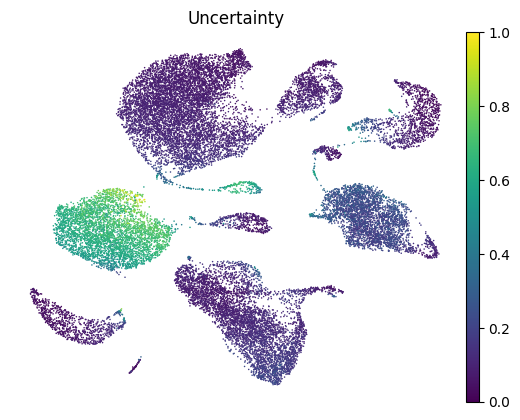

Starting with Liver...


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


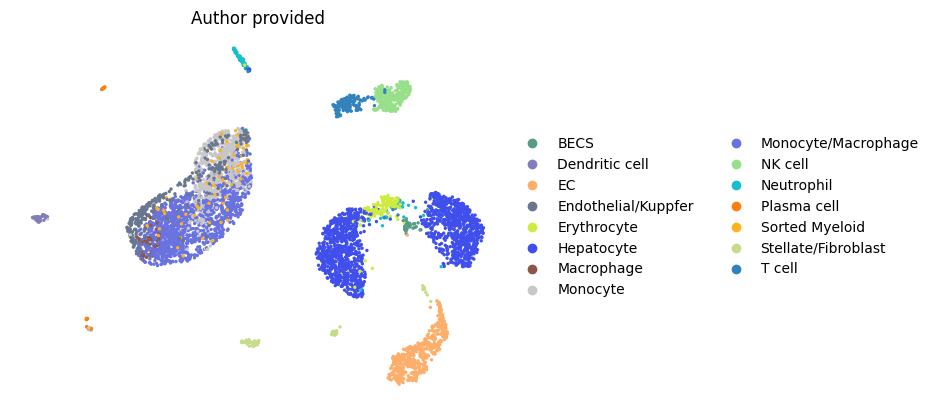

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


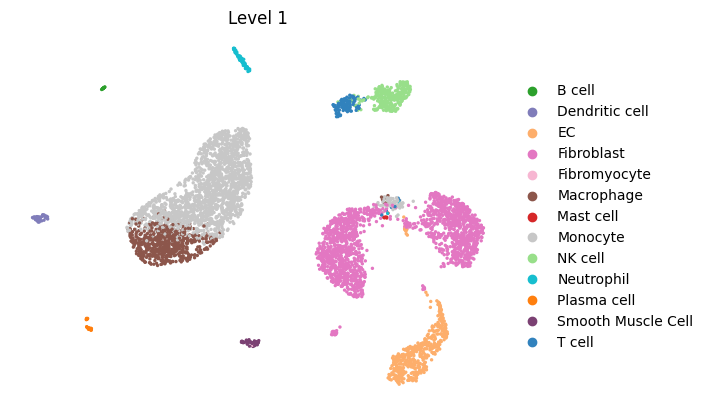

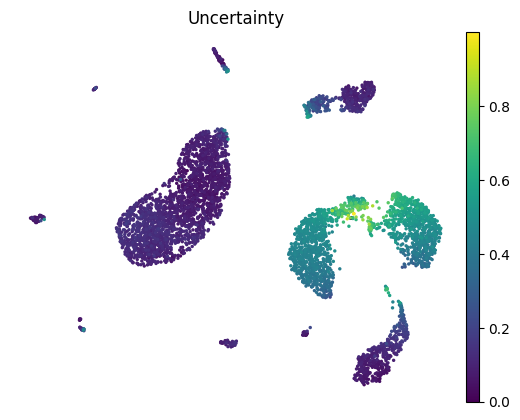

Starting with Kidney...


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


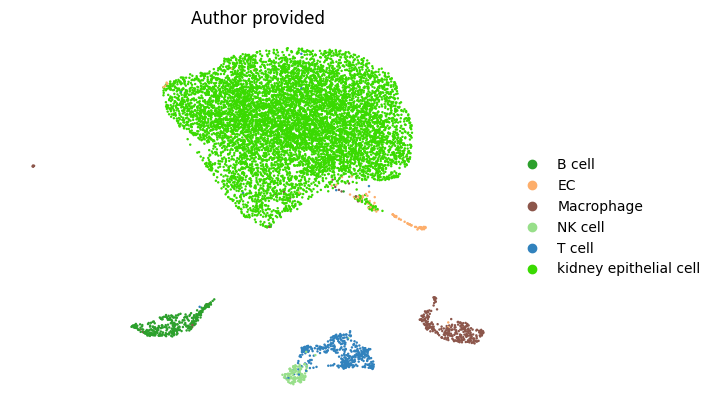

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


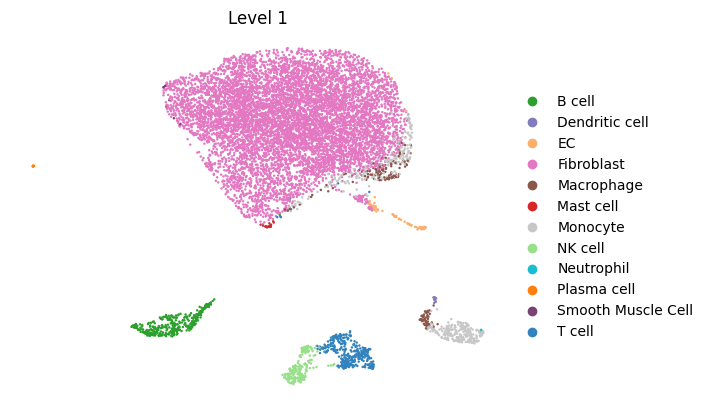

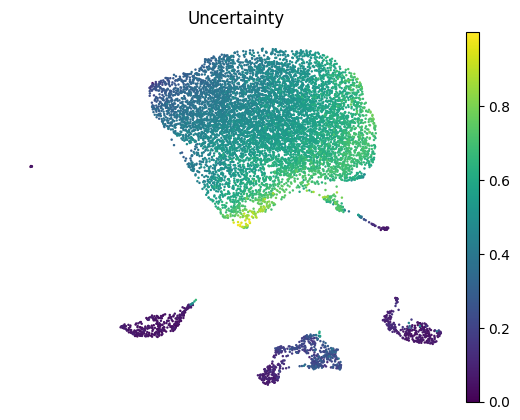

Starting with Vasculature...


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


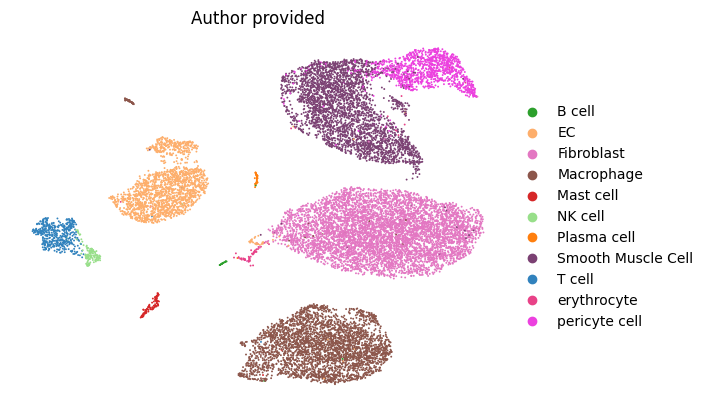

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


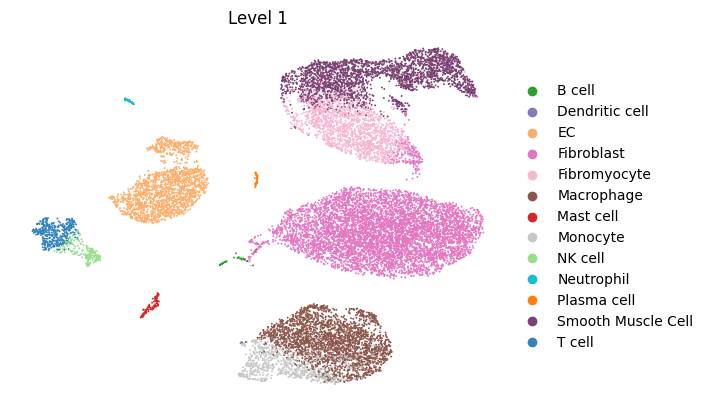

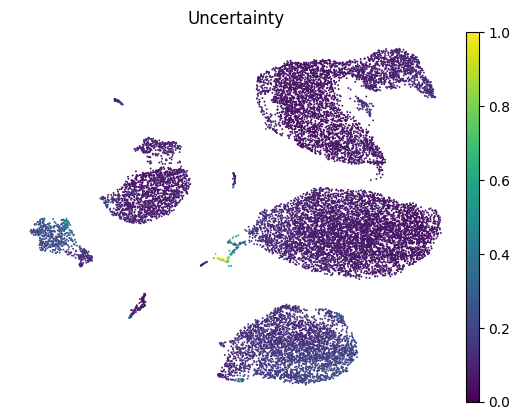

'\n    sc.pl.umap(\n            adata,\n            color=[\'cell_type_level2\'],\n            palette=color_palette_level2,\n            show=True,\n            frameon=False,\n            title = "Level 2",\n            save=f"{tissue}_level2_new.pdf"\n        )\n'

In [13]:
for tissue in ["Bladder", "Liver", "Kidney", "Vasculature"]: 
    print(f"Starting with {tissue}...")
    if tissue == "Bladder":
        Roche_mapping_dict = {
            "T cell": ["t cell"],
            "B cell": ["b cell"],
            "Fibroblast": ["fibroblast"],
            "Fibromyocyte": ["Fibromyocyte"],
            "EC": ["capillary endothelial cell", "endothelial cell of lymphatic vessel", "vein endothelial cell"],
            "Macrophage": ["macrophage"],
            "NK cell": ["nk cell"],
            "Smooth Muscle Cell": ["smooth muscle cell"],
            "Mast cell": ["mast cell"],
            "Plasma cell": ["plasma cell"],
            "Dendritic cell": ["plasmacytoid dendritic cell"]
        }
    
    elif tissue == "Kidney":
        Roche_mapping_dict = {
            "T cell": ["cd8-positive, alpha-beta t cell" , "cd4-positive helper t cell"],
            "B cell": ["b cell"],
            "EC": ["endothelial cell"],
            "Macrophage": ["macrophage"],
            "NK cell": ["nk cell"],
    }
    
    elif tissue == "Liver":
        Roche_mapping_dict = {
            "T cell": ["T cell"],
            "EC": ["Endothelial"],
            "NK cell": ["NK cell", "Proliferating NK cell"],
            "Dendritic cell": ["Dendritic cell"],
            "Plasma cell": ["Plasma"]
    }
    
    elif tissue == "Vasculature":
        Roche_mapping_dict = {
            "T cell": ["t cell"],
            "Smooth Muscle Cell": ["smooth muscle cell"],
            "Plasma cell": ["plasma cell"],
            "NK cell": ["nk cell"],
            "Mast cell": ["mast cell"],
            "Macrophage": ["macrophage"],
            "EC": ["lymphatic endothelial cell","artery endothelial cell", "endothelial cell", "epithelial cell"],
            "Fibroblast": ["fibroblast"],
            "B cell": ["b cell"]
    }

    adata = sc.read_h5ad(f"healthy_mapping/TS/{tissue}1/{tissue}_embedding.h5ad")
    sc.pp.neighbors(adata, n_neighbors=15)
    sc.tl.umap(adata)

    inverted_Roche_mapping = {v: k for k, values in Roche_mapping_dict.items() for v in values}

    # rename the "free_annotation" obs cell types according to the mapping dict. if its not in the mapping, keep the original
    adata.obs['mapped_annotation'] = adata.obs['free_annotation'].map(lambda x: inverted_Roche_mapping.get(x, x))

    
    plot_umap_with_dynamic_colors(
        adata,
        color_column='mapped_annotation',
        color_palette=color_palette_level1,
        title="Author provided",
        save_path=f"{tissue}_TS_labels_newcolors_paper.pdf",
        tissue=tissue
    )

    sc.settings.figdir = f"healthy_mapping/TS/{tissue}1/"

    sc.pl.umap(
            adata,
            color=['cell_type_level1'],
            show=True,
            frameon=False,
            palette=color_palette_level1,
            title = "Level 1",
            save=f"{tissue}_level1_paper.pdf"
        )
        
    sc.pl.umap(
            adata,
            color= ['cell_type_uncert'],
            show=True,
            frameon=False,
            title = "Uncertainty",
            save=f"{tissue}_uncert_paper.pdf"
        )
'''
    sc.pl.umap(
            adata,
            color=['cell_type_level2'],
            palette=color_palette_level2,
            show=True,
            frameon=False,
            title = "Level 2",
            save=f"{tissue}_level2_new.pdf"
        )
'''

In [22]:
def plot_confusion_matrix(adata, tissue):

    adata = sc.read_h5ad(f"healthy_mapping/TS/{tissue}1/{tissue}_embedding.h5ad")

    # remove organ specific cell types
    if tissue == "Bladder":
        remove = ["bladder urothelial cell"]
    elif tissue == "Liver":
        remove = ["Erythrocyte", "Hepatocyte"]
    elif tissue == "Kidney":
        remove = ["kidney epithelial cell"]
    elif tissue == "Vasculature":
        remove = ["erythrocyte"]
    else:
        remove = ["dummy"]

    adata = adata[~adata.obs['free_annotation'].isin(remove), :].copy()

    adata = adata[adata.obs['cell_type_uncert'] < 0.7].copy()
    # Create a cross-tabulation with absolute counts
    confusion_abs = pd.crosstab(adata.obs['free_annotation'], 
                                adata.obs['cell_type_level1'])
    
    # Create a normalized version for color mapping
    confusion_norm = confusion_abs.div(confusion_abs.sum(axis=1), axis=0)
    
    # Calculate dynamic figure size
    n_rows, n_cols = confusion_abs.shape
    #figsize = (max(12, n_cols * 0.6), max(10, n_rows * 0.6))
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12,10))
    
    # Create the heatmap using imshow
    im = ax.imshow(confusion_norm, cmap='Blues', aspect='auto')
    
    # Add text annotations for absolute counts
    for i in range(n_rows):
        for j in range(n_cols):
            count = confusion_abs.iloc[i, j]
            color = 'white' if confusion_norm.iloc[i, j] > 0.5 else 'black'
            ax.text(j, i, str(count), ha='center', va='center', color=color, fontsize=15)
    
    # Set labels and title
    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('Author provided label', fontsize=14)
    ax.set_title(tissue, fontsize=16)
    
    # Set tick labels
    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))
    ax.set_xticklabels(confusion_abs.columns)
    ax.set_yticklabels(confusion_abs.index)
    
    # Increase the font size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    
    # Add a grid
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Adjust layout to prevent clipping of labels
    plt.tight_layout()
    
    # Show the plot
    #plt.show()
    
    # Uncomment to save the plot
    plt.savefig(f'healthy_mapping/TS/{tissue}1/conf_matrix_{tissue}.pdf', dpi=300, bbox_inches='tight')

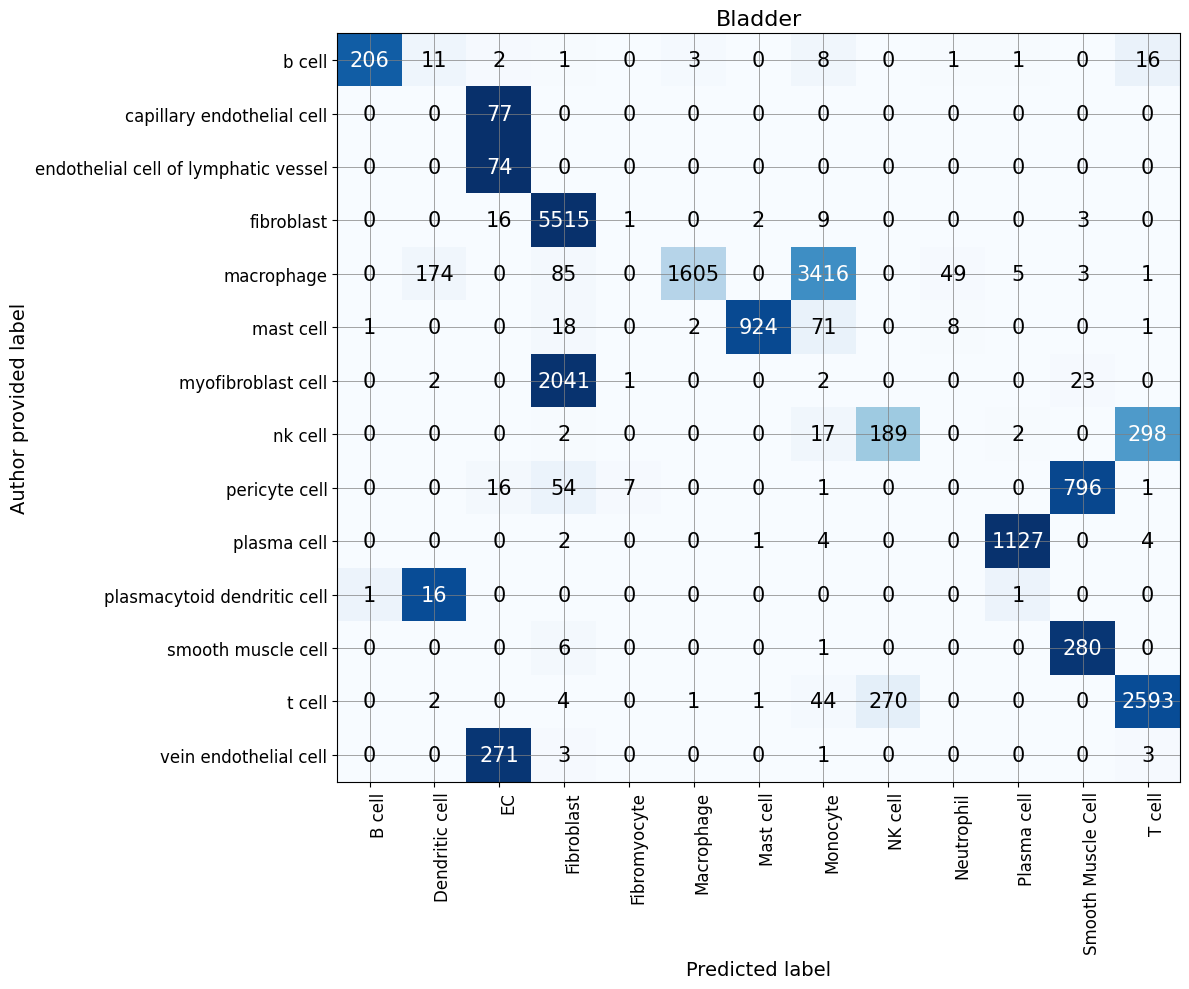

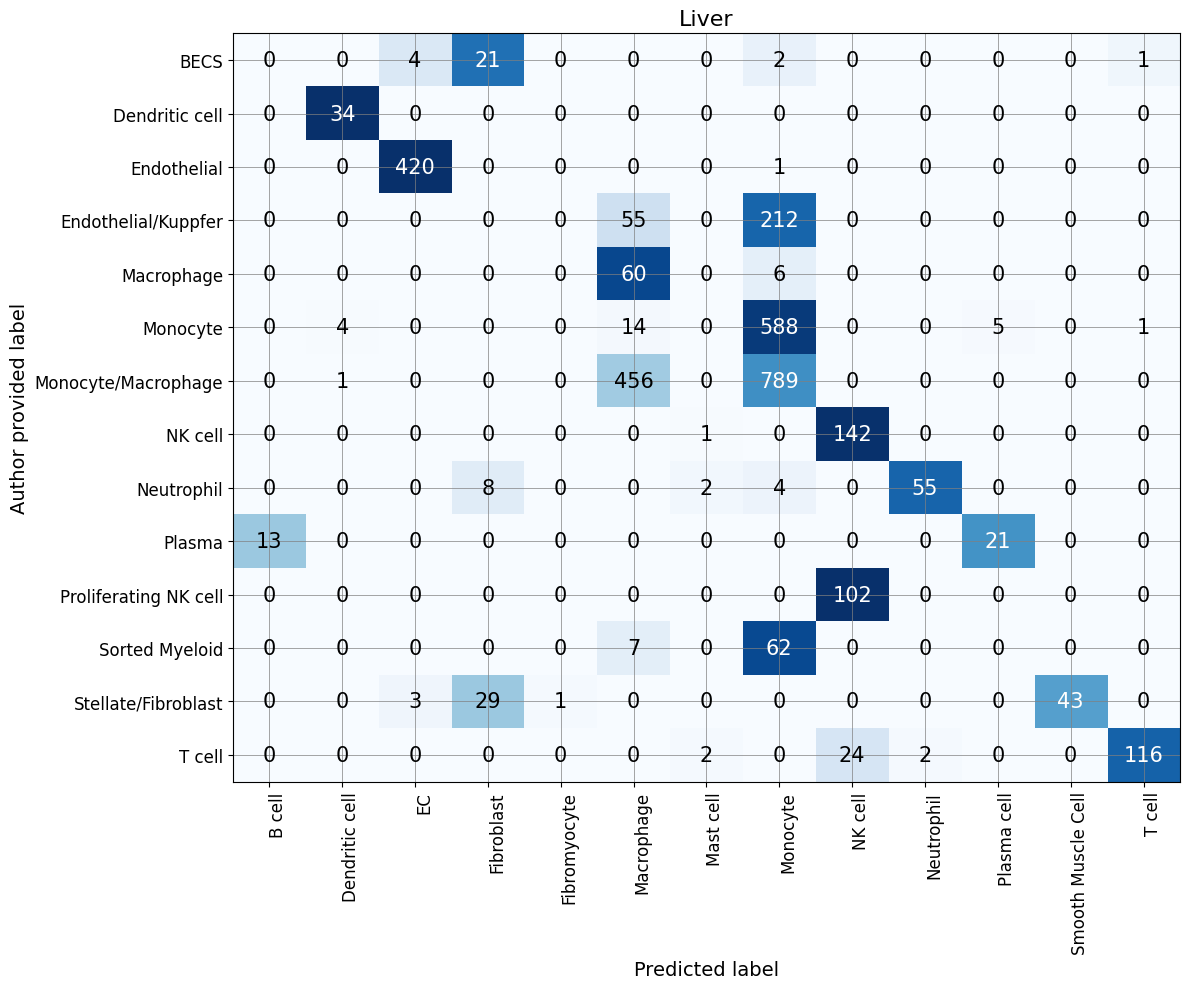

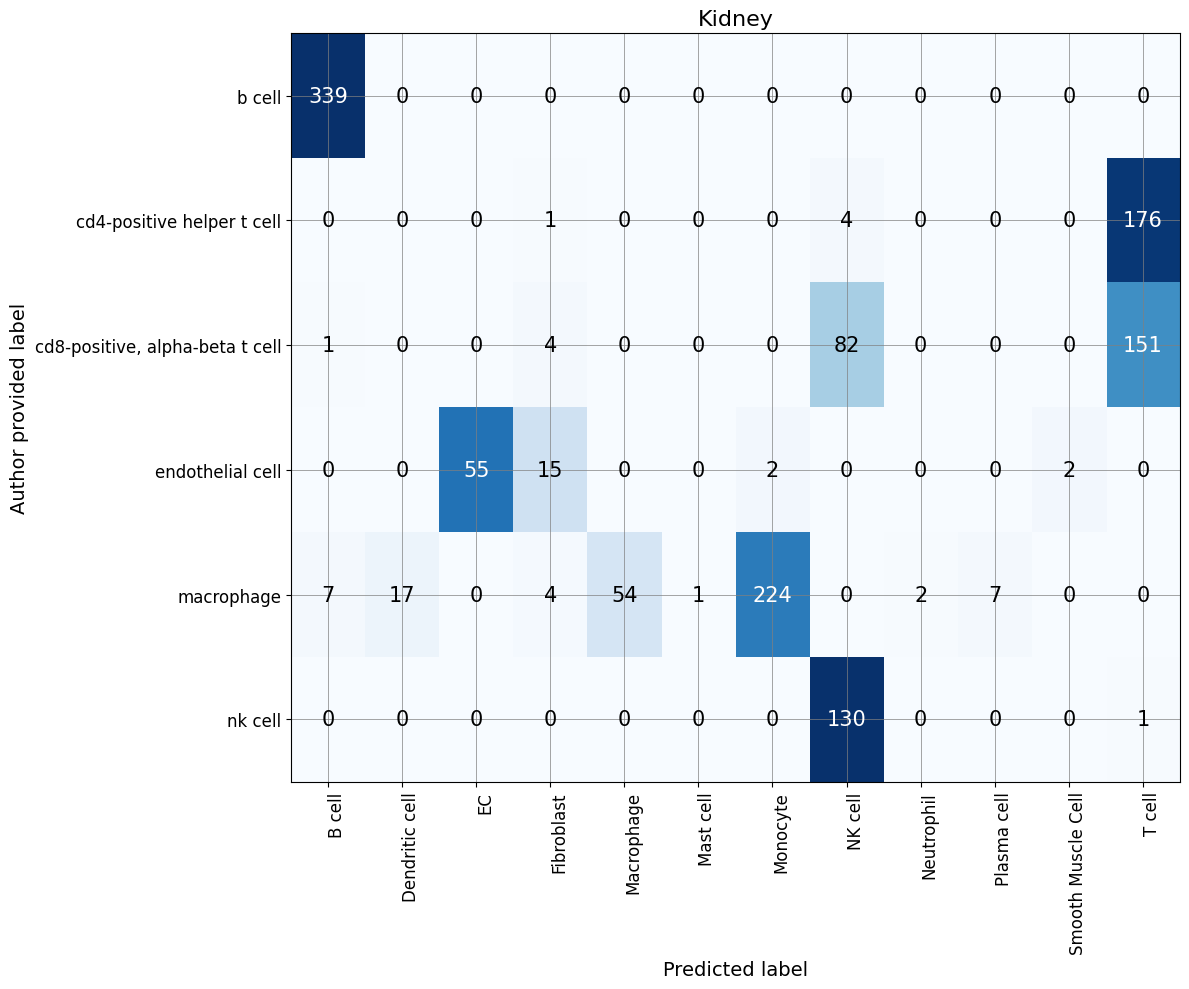

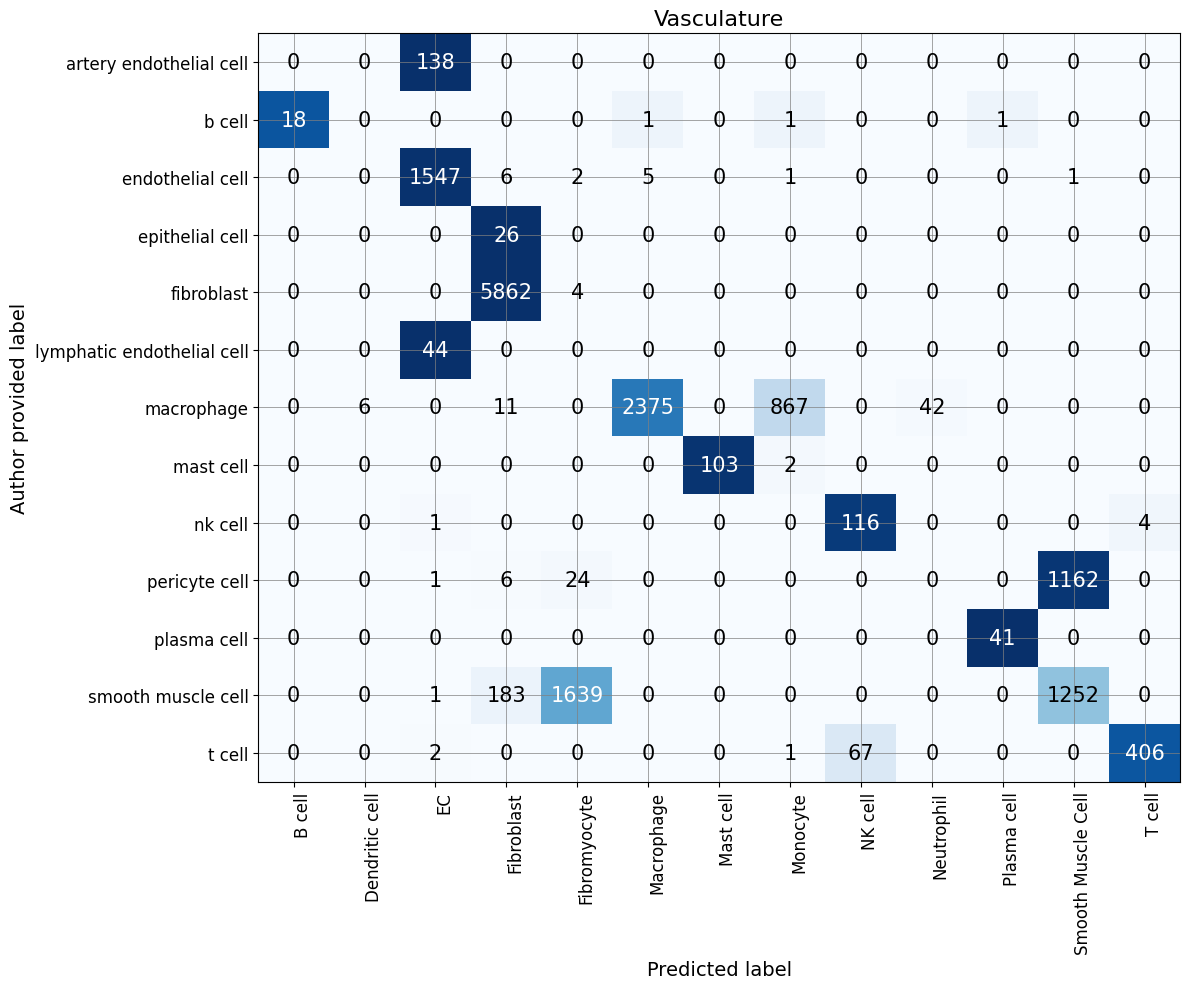

In [23]:
for tissue in ["Bladder", "Liver", "Kidney", "Vasculature"]: 
    plot_confusion_matrix(adata, tissue)

In [18]:
# abundances

Generate plots for Vasculature2
Percentage of Fibromyocyte in Vasculature2: 10.98%
Generate plots for Bladder2
Percentage of Fibromyocyte in Bladder2: 0.03%
Generate plots for germline2
Generate plots for Eye2
Percentage of Fibromyocyte in Eye2: 0.00%
Generate plots for Kidney2
Percentage of Fibromyocyte in Kidney2: 0.00%
Generate plots for Skin2
Percentage of Fibromyocyte in Skin2: 0.00%
Generate plots for Bone_Marrow2
Percentage of Fibromyocyte in Bone_Marrow2: 0.00%
Generate plots for Uterus2
Percentage of Fibromyocyte in Uterus2: 0.12%
Generate plots for Lung2
Percentage of Fibromyocyte in Lung2: 0.08%
Generate plots for Small_Intestine2
Percentage of Fibromyocyte in Small_Intestine2: 0.00%
Generate plots for Heart2
Percentage of Fibromyocyte in Heart2: 0.02%
Generate plots for Lymph_Node2
Percentage of Fibromyocyte in Lymph_Node2: 0.00%
Generate plots for Muscle2
Percentage of Fibromyocyte in Muscle2: 0.00%
Generate plots for Tongue2
Percentage of Fibromyocyte in Tongue2: 0.03%
Ge

/tmp/ipykernel_562736/1169148580.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


Generate plots for Thymus2
Percentage of Fibromyocyte in Thymus2: 0.22%
Generate plots for Blood2
Percentage of Fibromyocyte in Blood2: 0.00%


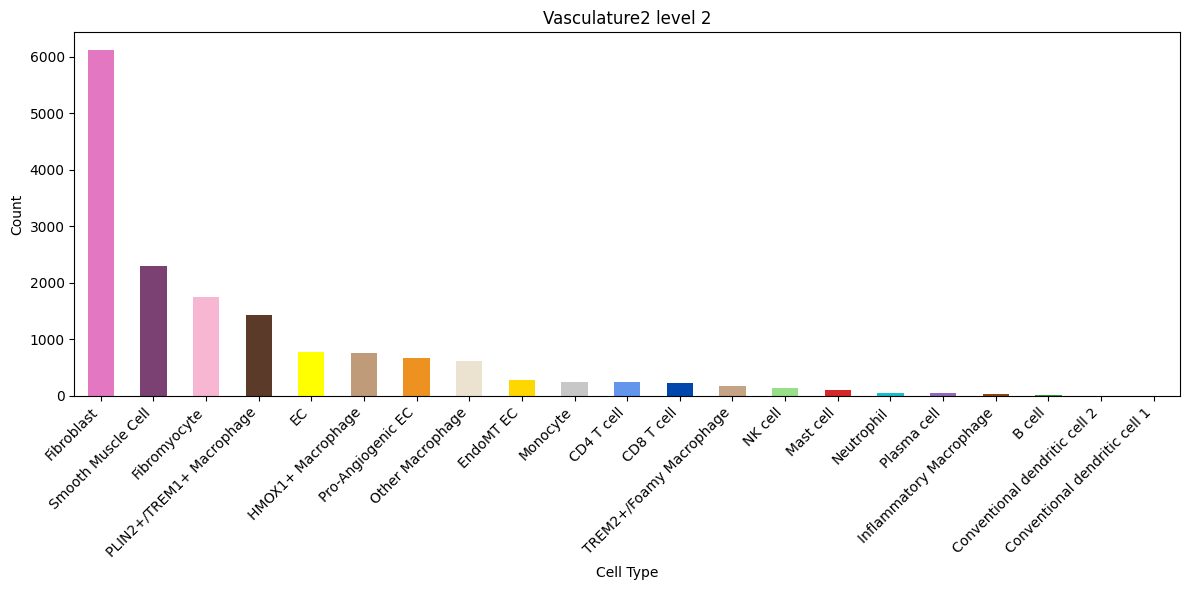

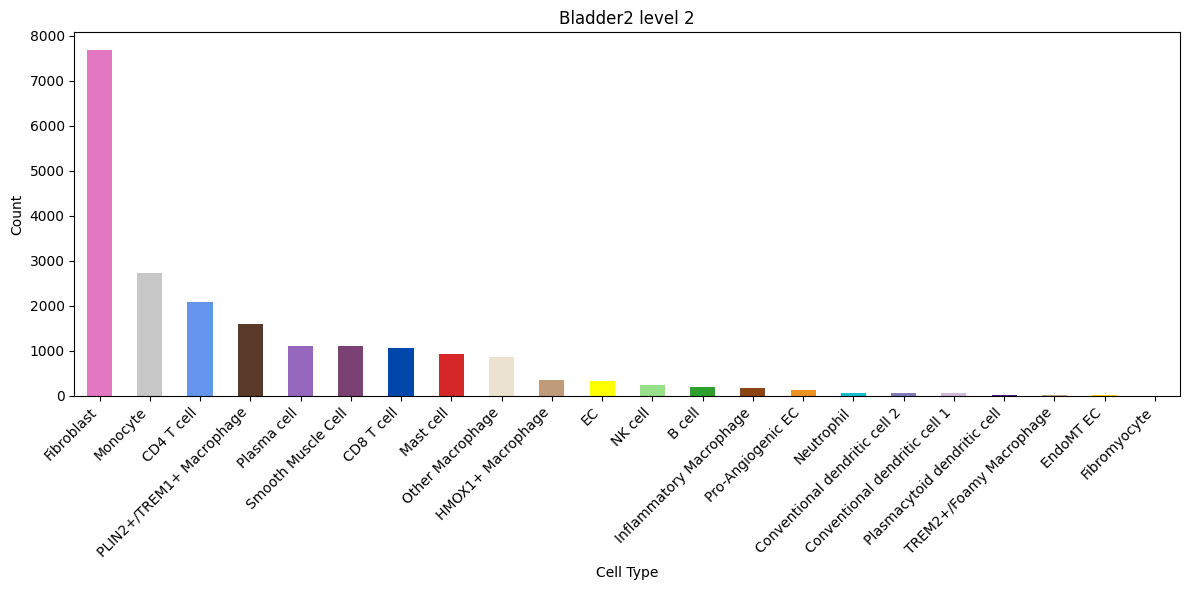

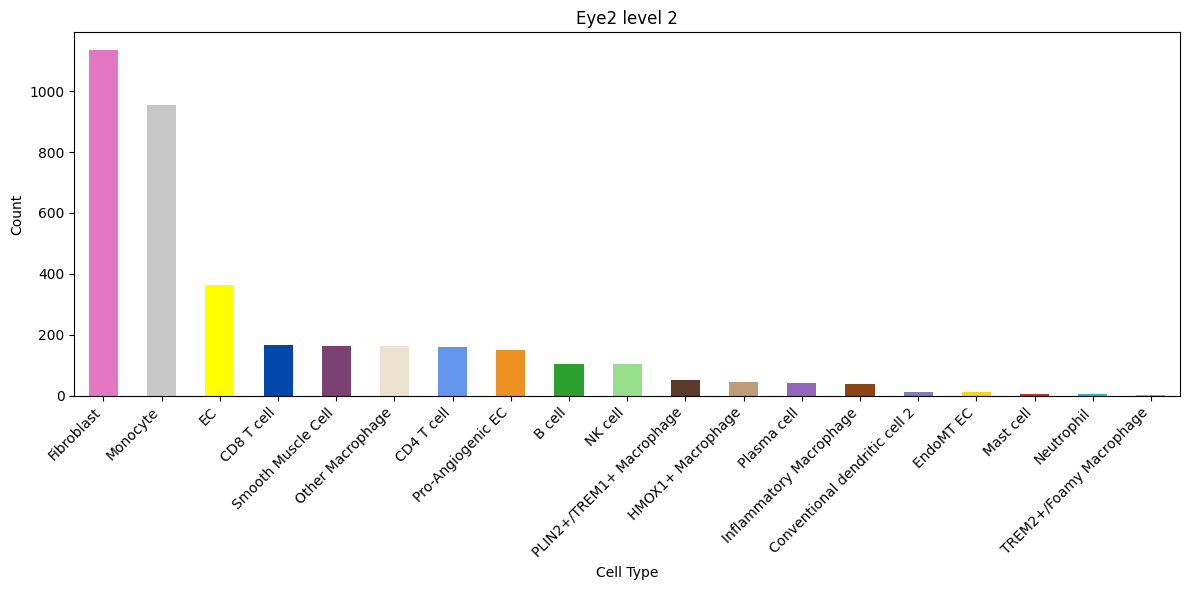

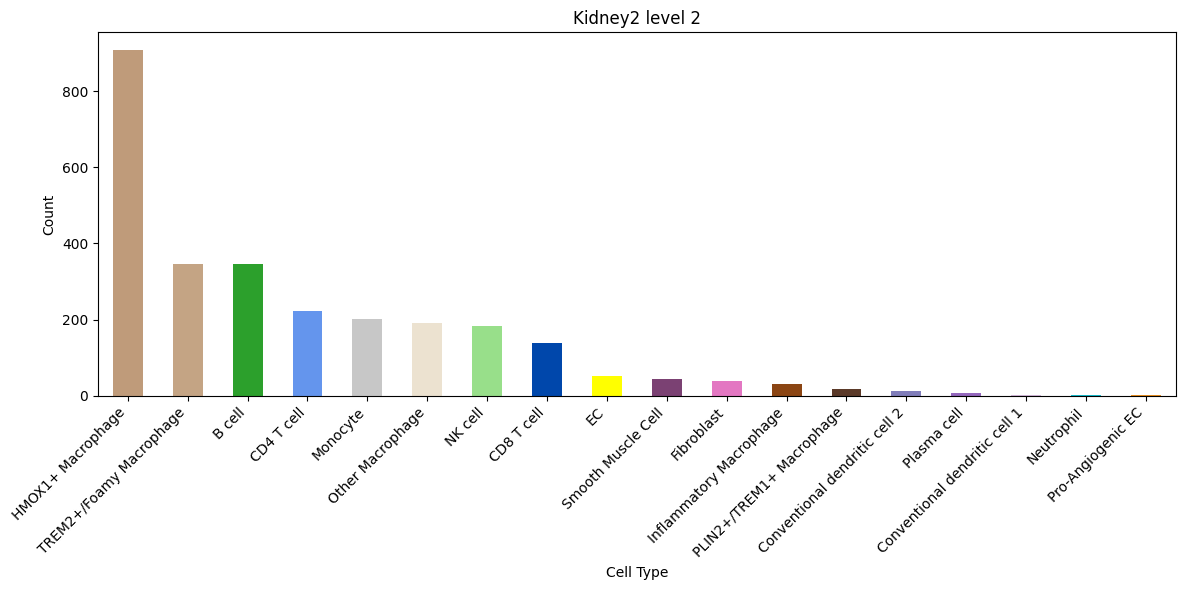

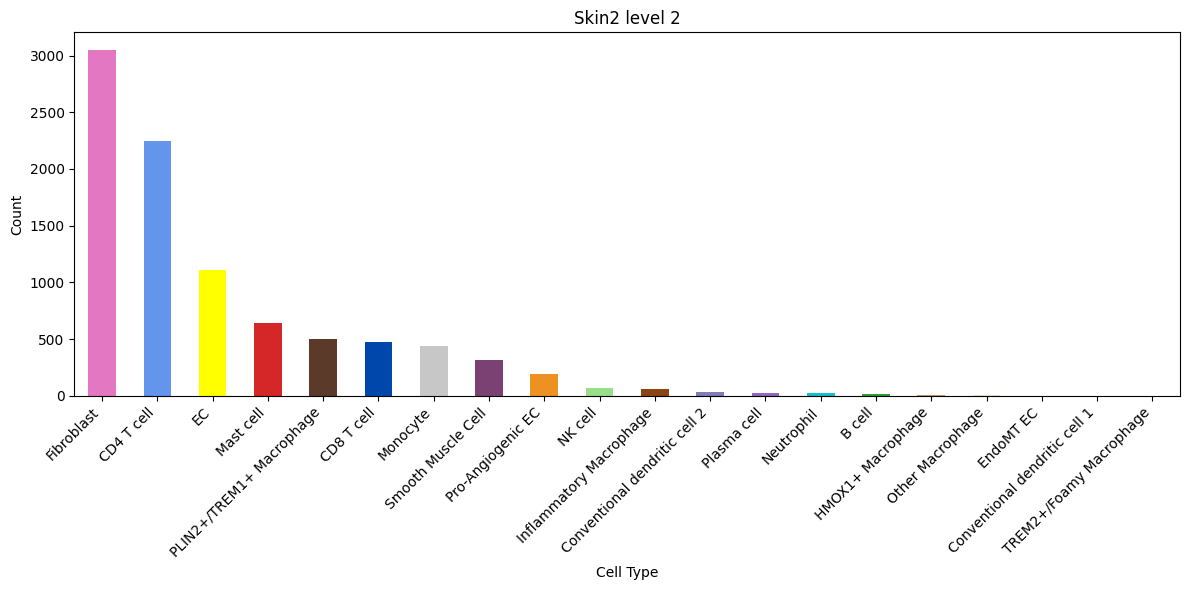

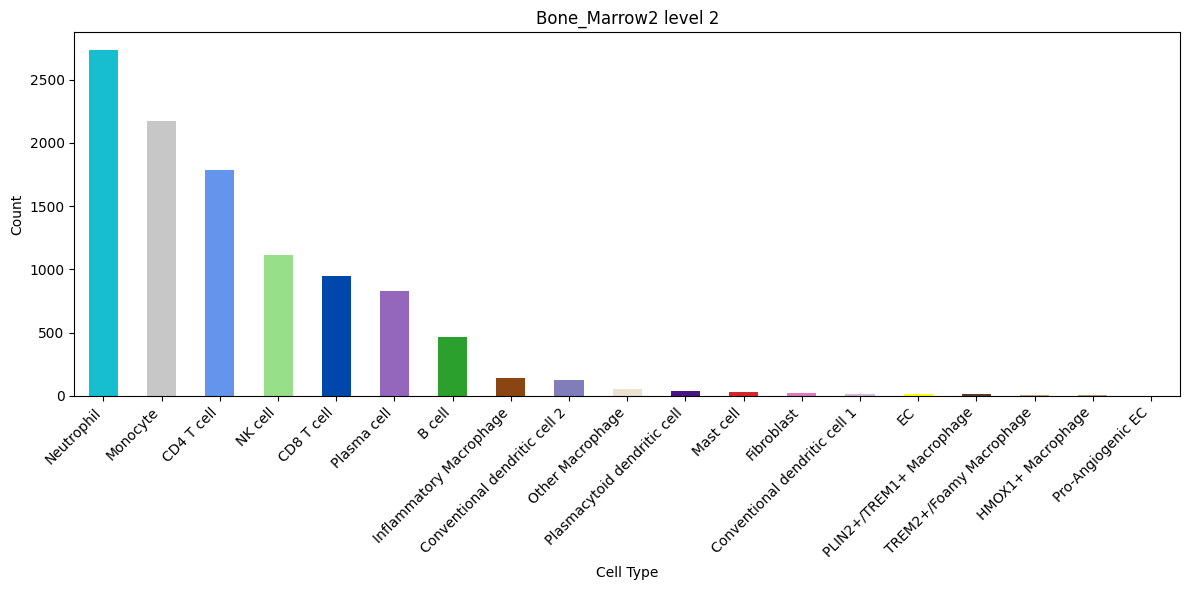

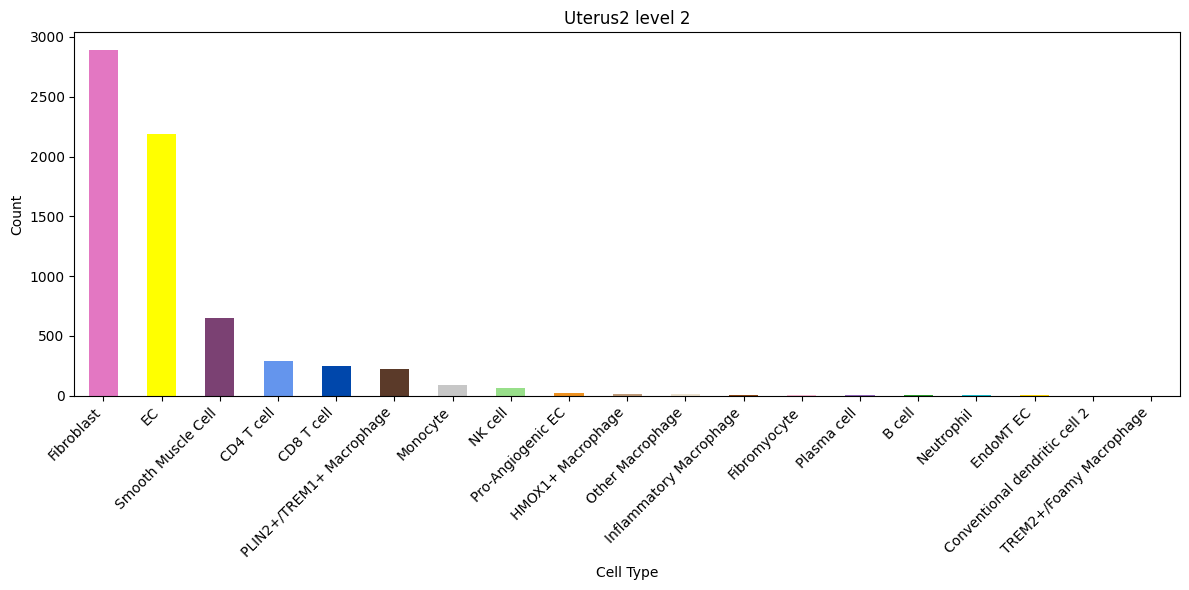

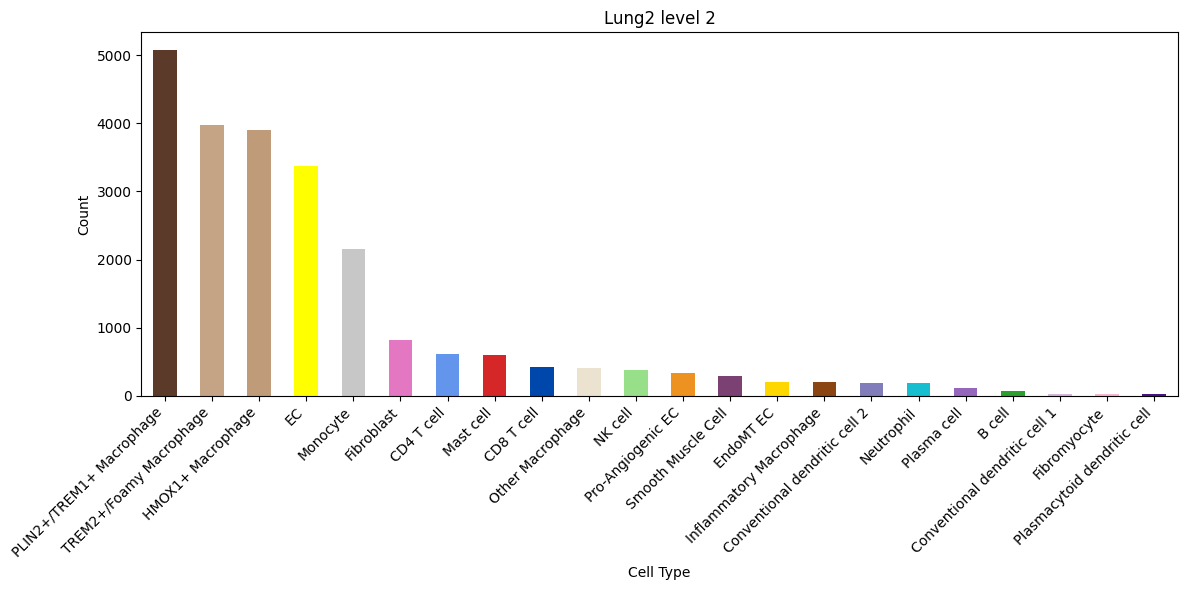

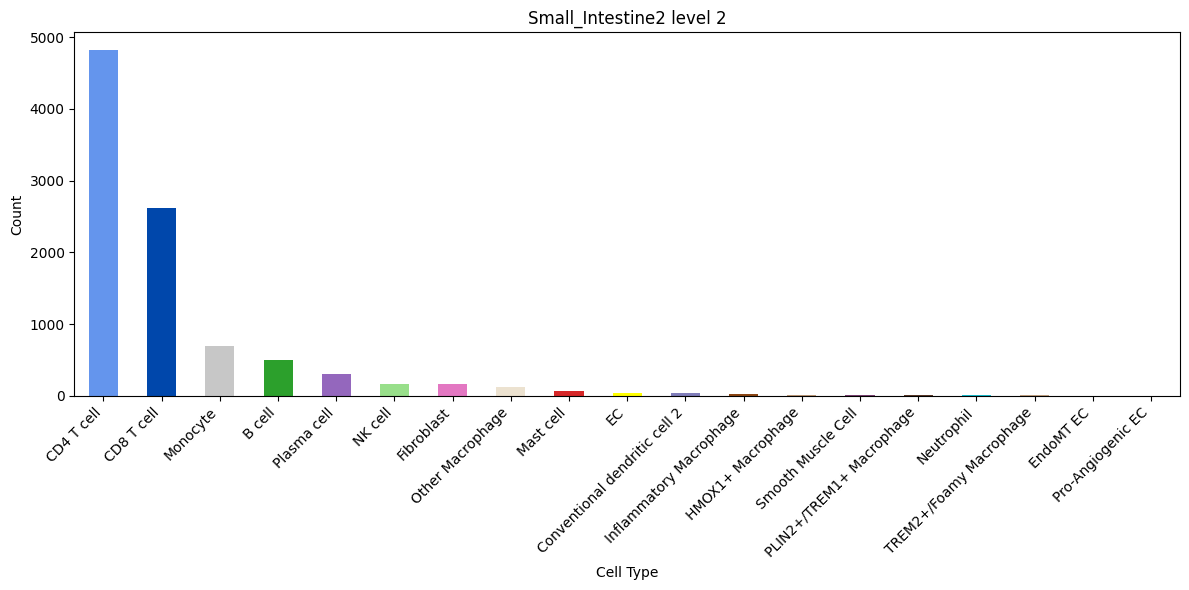

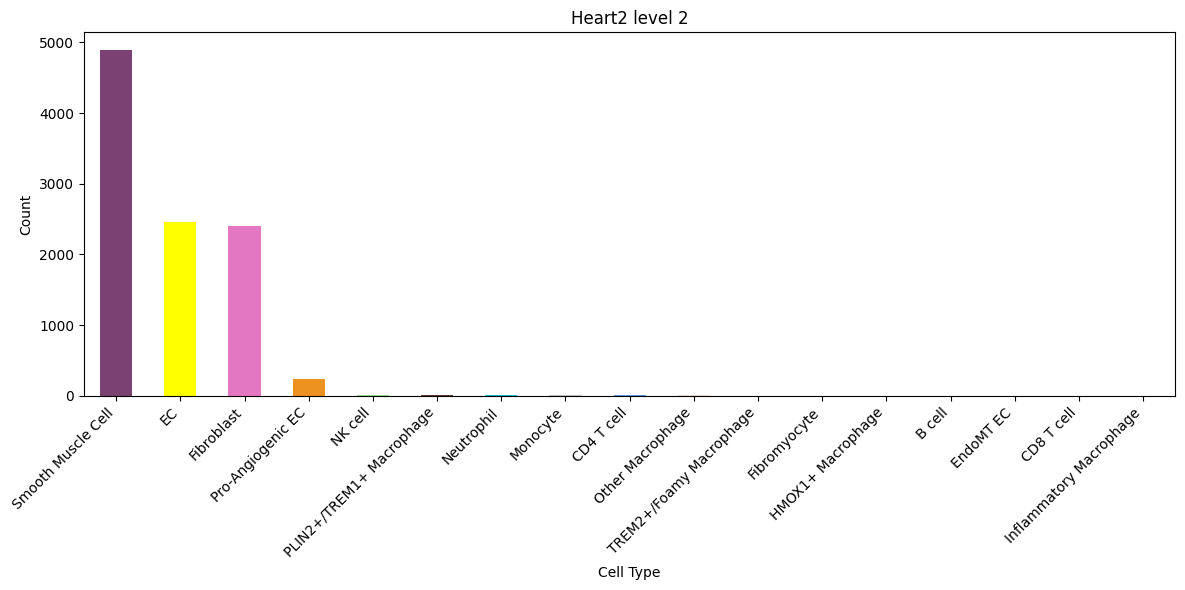

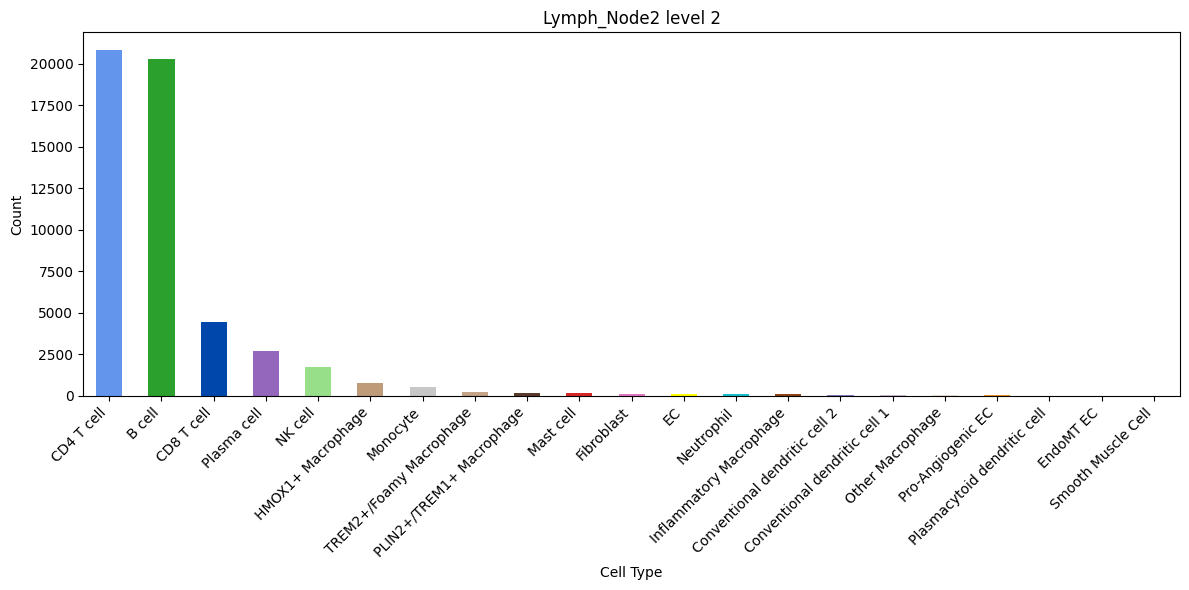

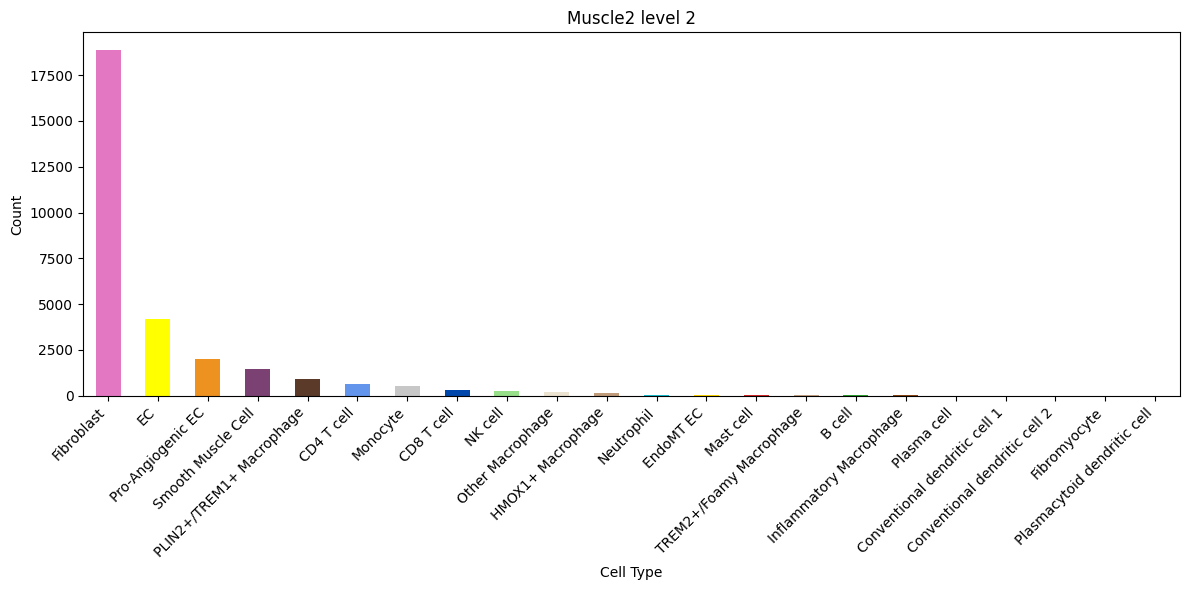

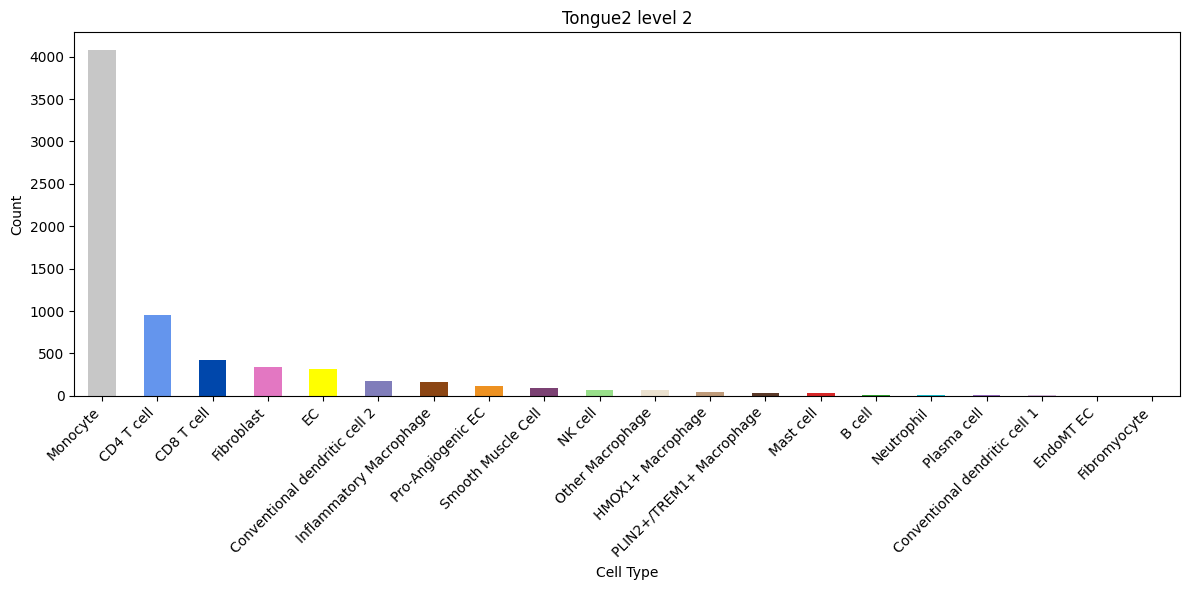

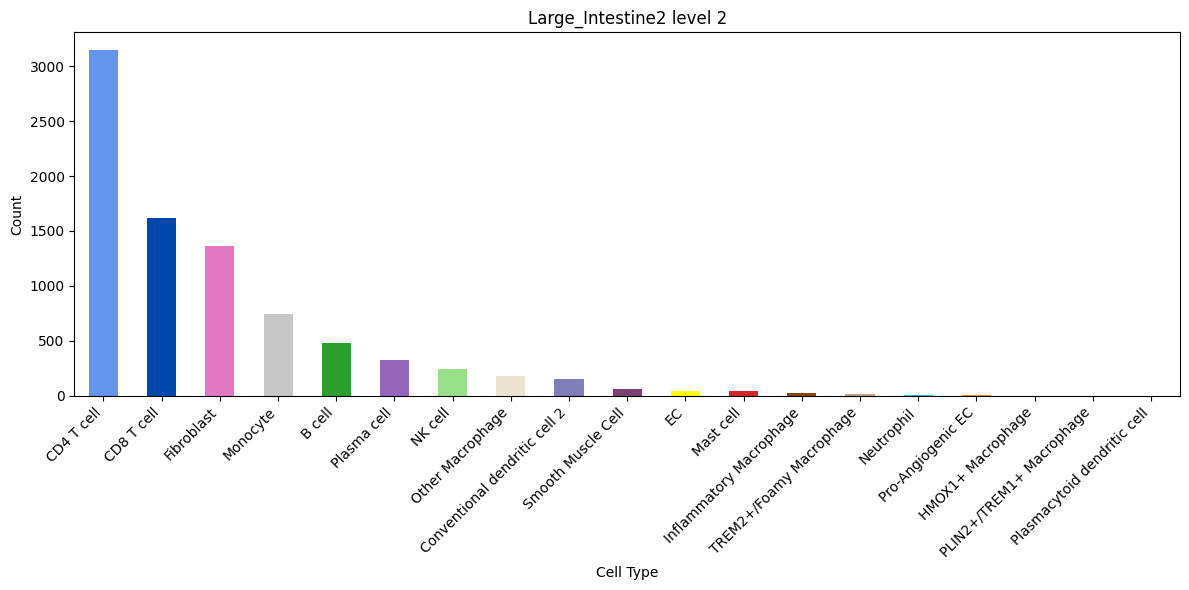

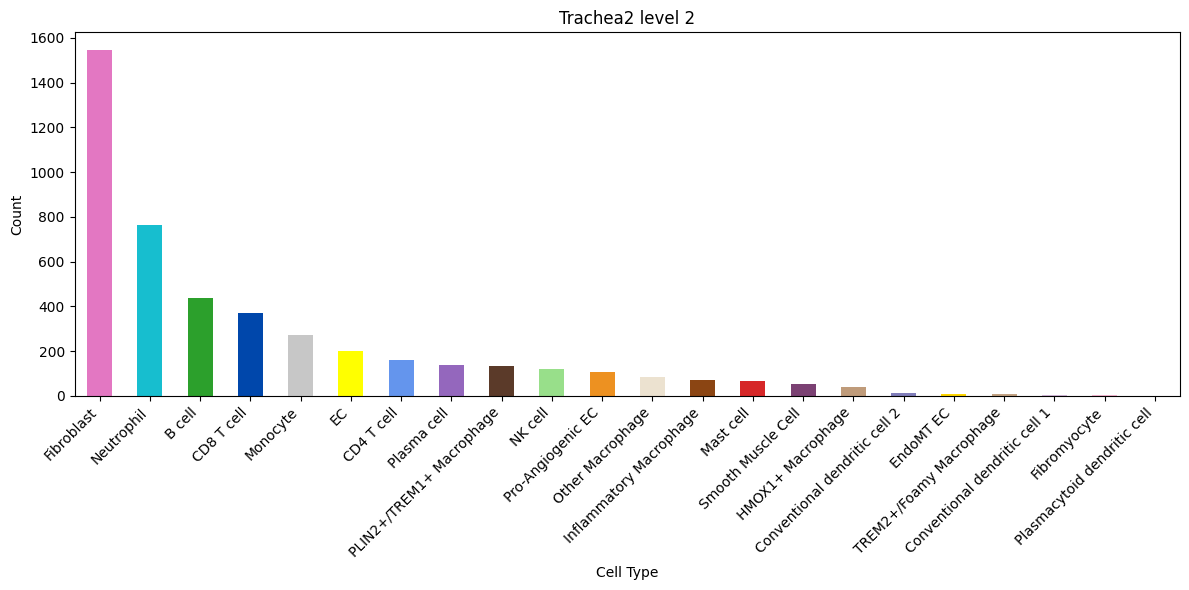

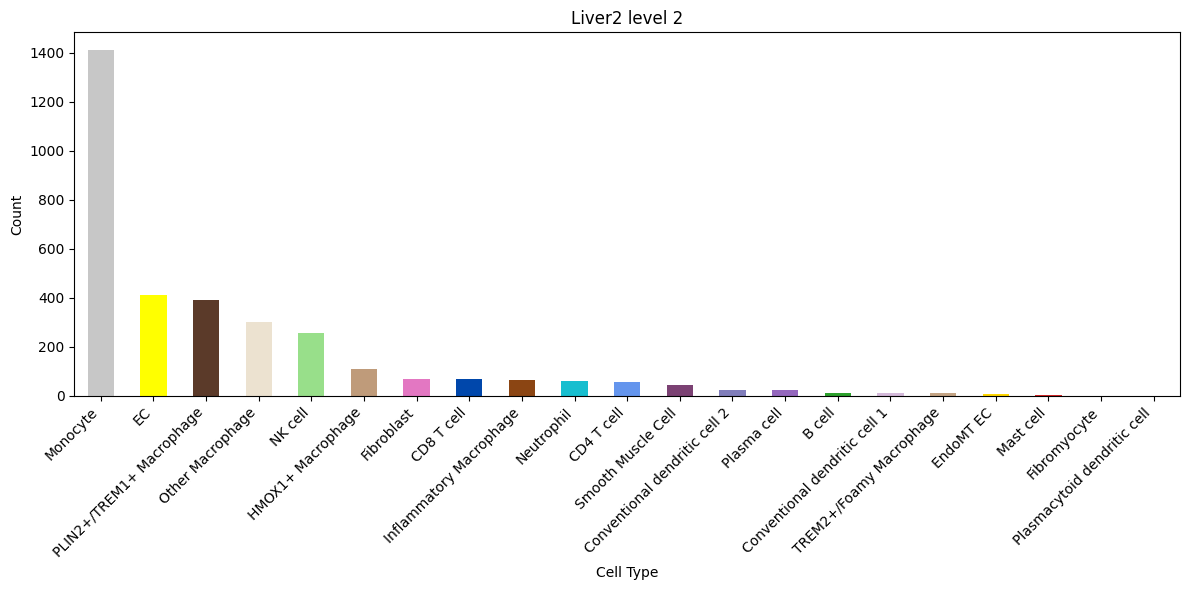

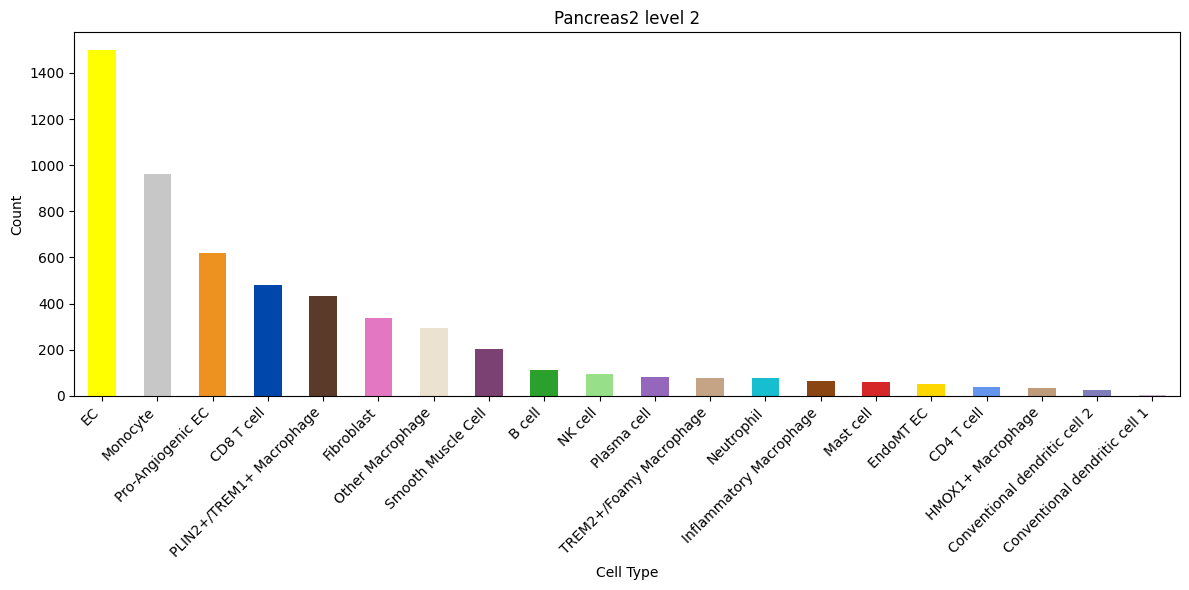

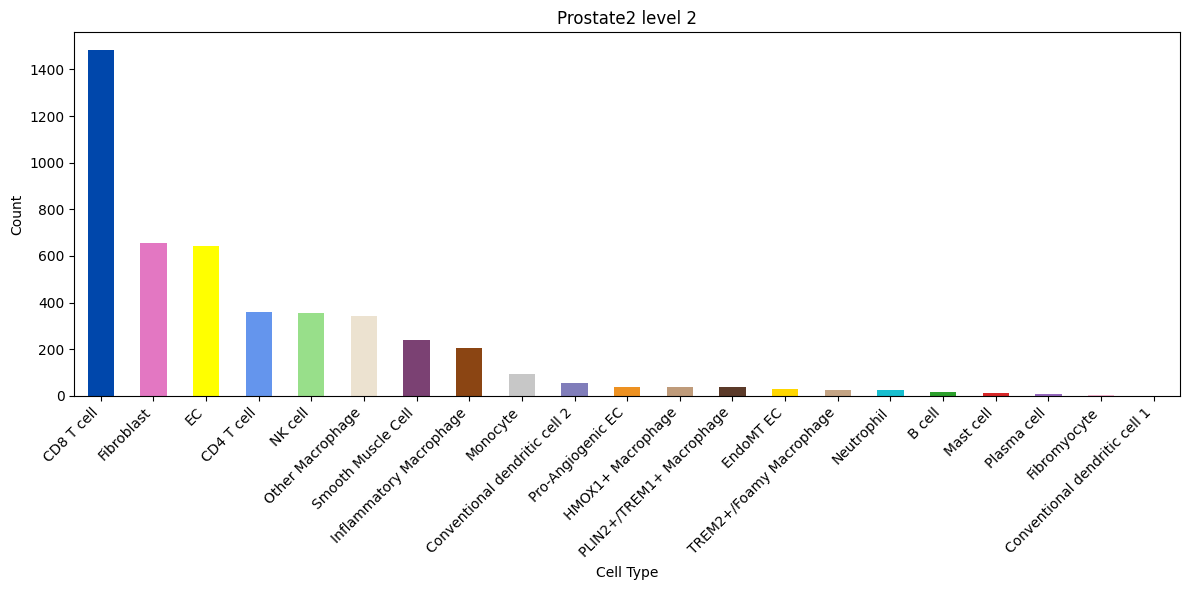

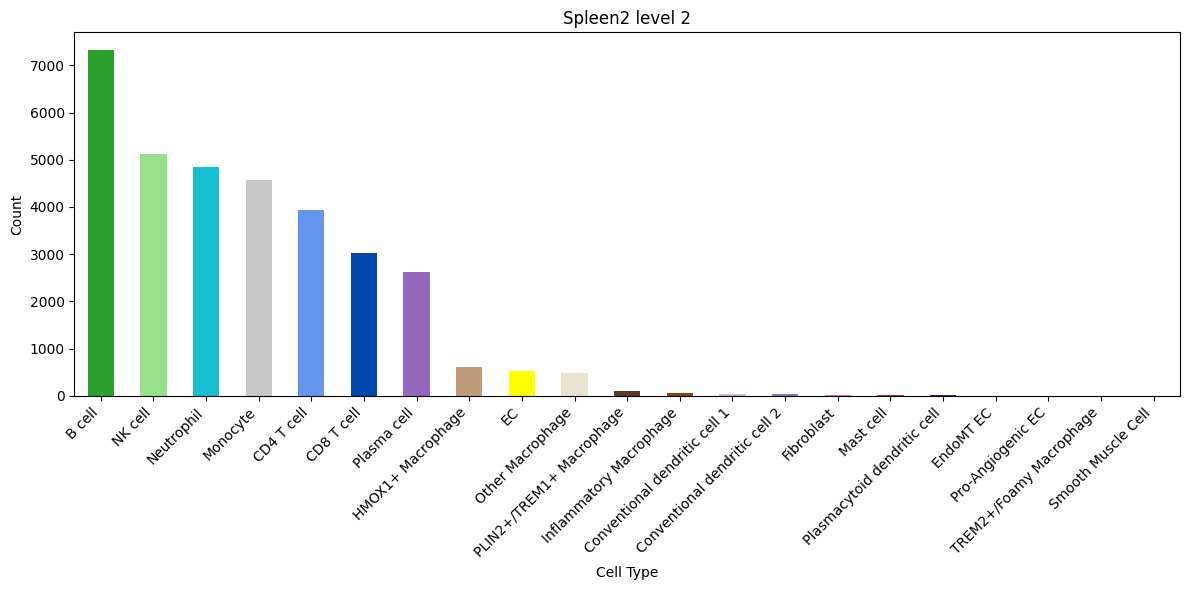

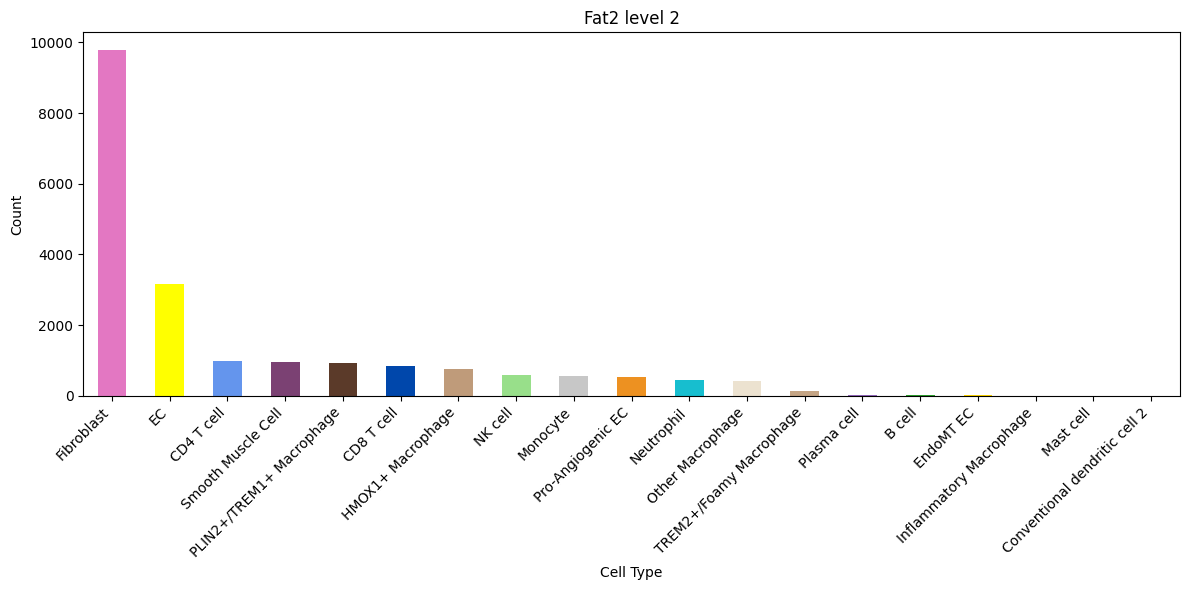

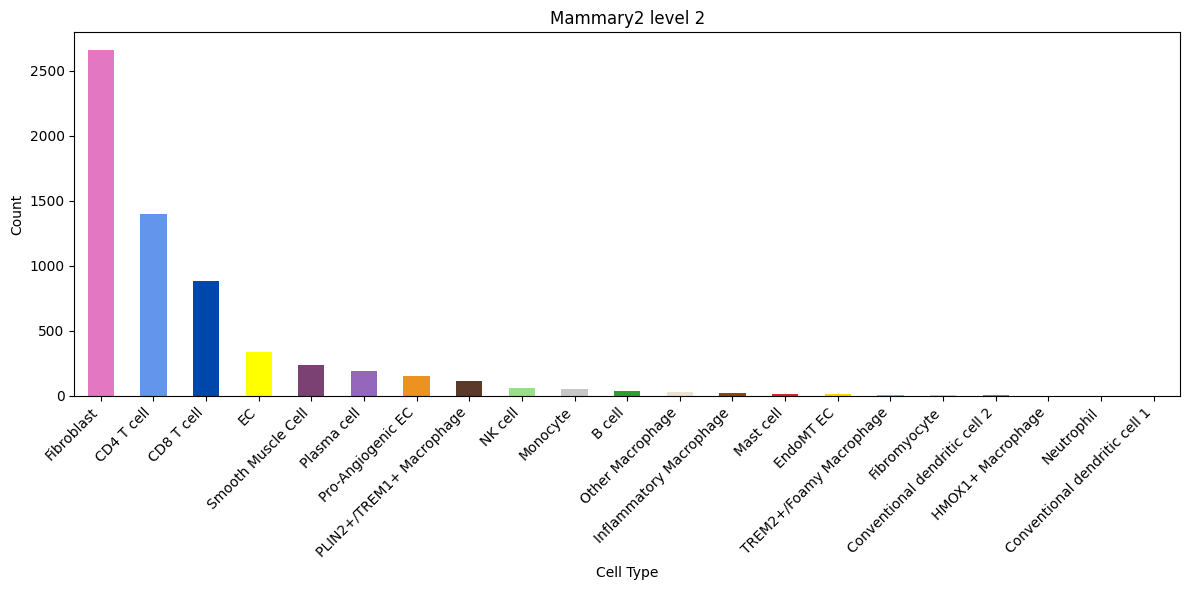

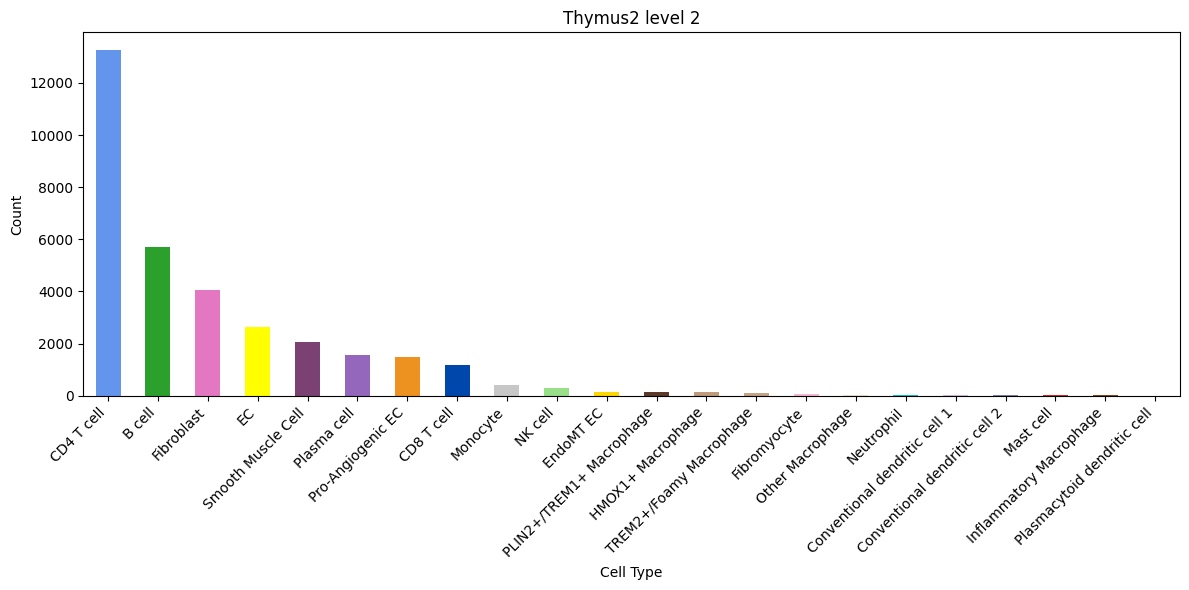

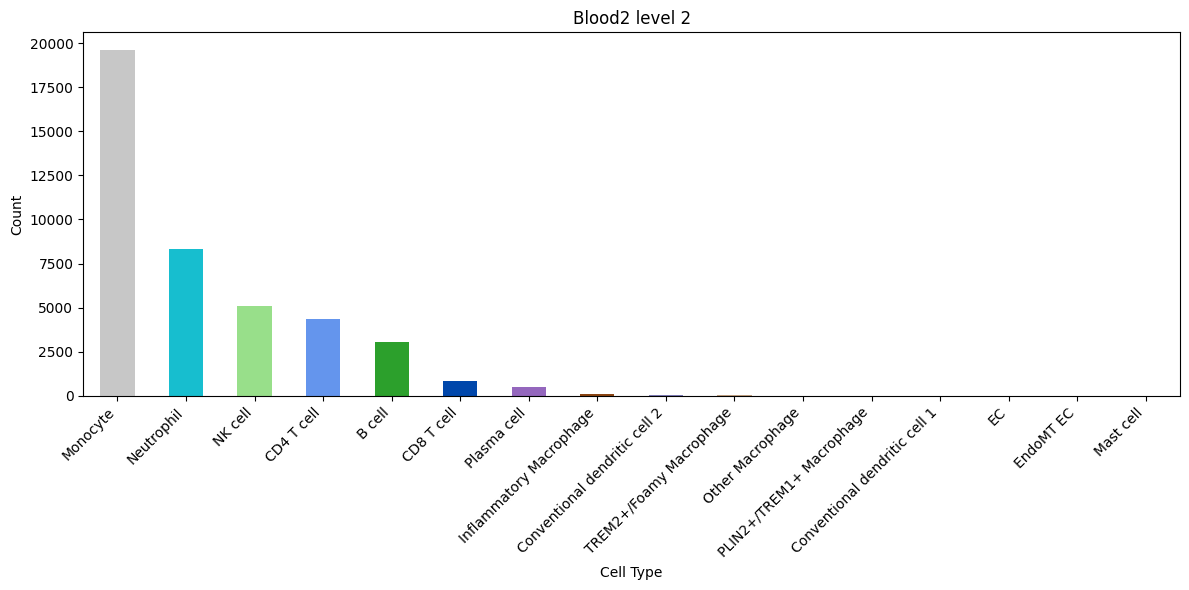

In [7]:
for tissue in os.listdir("healthy_mapping/TS"):
    #if "1" in tissue and "log" not in tissue:
    if "rev2" in tissue and "log" not in tissue:
        #tissue = tissue[:-1]
        tissue = tissue[:-5]
        print(f"Generate plots for {tissue}")
        #if tissue == "germline":
        if tissue == "germline2":
            pass
        else:
            #adata = sc.read_h5ad(f"healthy_mapping/TS/{tissue}2/{tissue}_embedding.h5ad")
            adata = sc.read_h5ad(f"healthy_mapping/TS/{tissue}-rev2/{tissue[:-1]}_embedding-rev2.h5ad")
        
            # Abundances 
            adata = adata[adata.obs['cell_type_uncert'] < 0.5].copy()

            '''
            # Assuming you've already run the value_counts() method
            cell_type_counts = adata.obs['cell_type_level1'].value_counts()
            
            # Create a bar chart
            plt.figure(figsize=(12, 6))
            
            # Plot bars and color them according to the palette
            bars = cell_type_counts.plot(kind='bar', color=[color_palette_level1.get(ct, '#333333') for ct in cell_type_counts.index])
            
            # Customize the chart
            plt.title(f"{tissue} level 1")
            plt.xlabel('Cell Type')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            
            # Remove the grid
            plt.grid(False)
            
            # Save the plot
            plt.show()
            #plt.savefig(f'healthy_mapping/TS/{tissue}1/cell_type_abundances_level1_{tissue}.png', dpi=300, bbox_inches='tight')
            '''

        
            
            # same for level 2
            cell_type_counts = adata.obs['cell_type_level2'].value_counts()

            fibromyocyte_percentage = (cell_type_counts.get("Fibromyocyte", 0) / cell_type_counts.sum()) * 100
            
            print(f"Percentage of Fibromyocyte in {tissue}: {fibromyocyte_percentage:.2f}%")
            
            # Create a bar chart
            plt.figure(figsize=(12, 6))
            
            # Plot bars and color them according to the palette
            bars = cell_type_counts.plot(kind='bar', color=[color_palette_level2.get(ct, '#333333') for ct in cell_type_counts.index])
            
            # Customize the chart
            plt.title(f"{tissue} level 2")
            plt.xlabel('Cell Type')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            
            # Remove the grid
            plt.grid(False)
            
            # Save the plot
            #plt.savefig(f'healthy_mapping/TS/{tissue}2/cell_type_abundances_level2_{tissue}.pdf', bbox_inches='tight')
            plt.savefig(f'healthy_mapping/TS/{tissue}-rev2/cell_type_abundances_level2_{tissue}-rev2.pdf', bbox_inches='tight')

            


# Hu abundance

In [ ]:
Hu_level1 = sc.read_h5ad("/ictstr01/groups/epigenereg01/workspace/users/korbinian.traeuble/projects/Roche/hpc-data-transfer/Roche_main/data/Plaque-atlas/healthy_mapping/Hu/Hu_full_level1.h5ad")
Hu_level2 = sc.read_h5ad("/ictstr01/groups/epigenereg01/workspace/users/korbinian.traeuble/projects/Roche/hpc-data-transfer/Roche_main/data/Plaque-atlas/healthy_mapping/Hu/Hu_full_level2-rev2.h5ad")

In [14]:
Hu_level1 = Hu_level1[Hu_level1.obs["cell_type_uncert"]<0.7].copy()
Hu_level2 = Hu_level2[Hu_level2.obs["cell_type_uncert"]<0.7].copy()

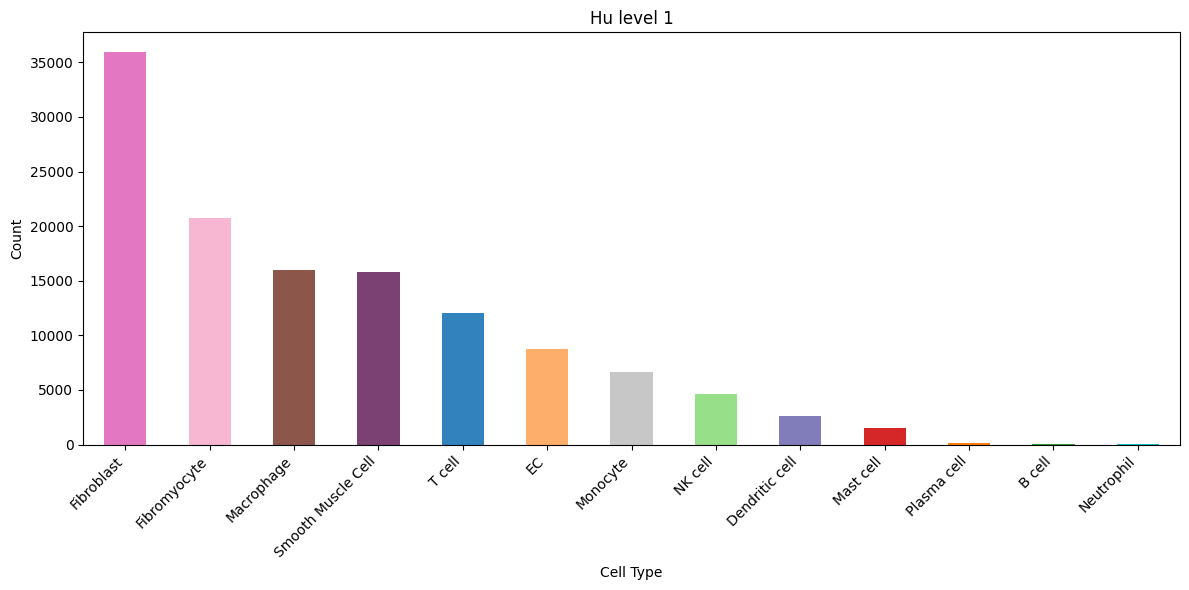

In [10]:
# Assuming you've already run the value_counts() method
cell_type_counts = Hu_level1.obs['cell_type_level1'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))

# Plot bars and color them according to the palette
bars = cell_type_counts.plot(kind='bar', color=[color_palette_level1.get(ct, '#333333') for ct in cell_type_counts.index])

# Customize the chart
plt.title(f"Hu level 1")
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Remove the grid
plt.grid(False)

# Save the plot
plt.savefig("figures/abundance_Hulvl1.pdf")
plt.show()

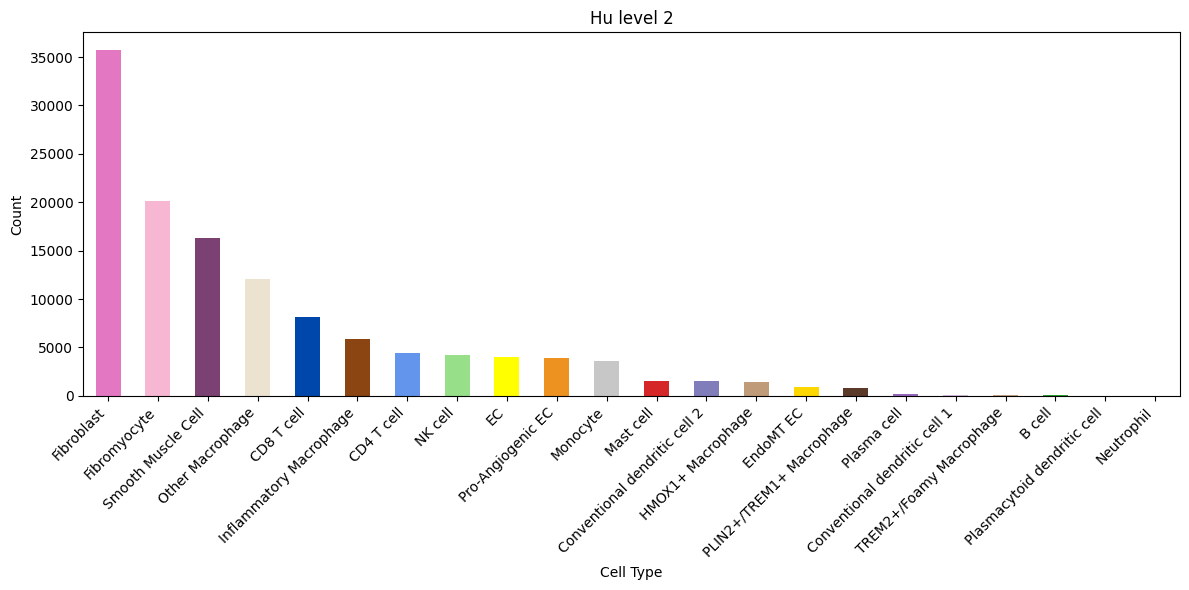

In [15]:
# Assuming you've already run the value_counts() method
cell_type_counts = Hu_level2.obs['cell_type_level2'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))

# Plot bars and color them according to the palette
bars = cell_type_counts.plot(kind='bar', color=[color_palette_level2.get(ct, '#333333') for ct in cell_type_counts.index])

# Customize the chart
plt.title(f"Hu level 2")
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Remove the grid
plt.grid(False)

# Save the plot
plt.savefig("figures/abundance_Hulvl2-rev2.pdf")
plt.show()